# Analysis of ENSO predictability

In [1]:
import sys
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/doppyo')

import re
import os
import dask
import glob
import scipy
import doppyo
import random
import sklearn
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import matplotlib as mpl
from mord import LogisticAT
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from matplotlib.collections import LineCollection

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/active_projects/paper_Risbey_Nature_ENSO/figures_proof/'

# Spin up a cluster

In [4]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(walltime='03:00:00', cores=10, memory='12GB', job_extra=['--qos="express"'])

In [5]:
cluster.scale(n=4)

In [6]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.141.1.47:41681 Dashboard: http://10.141.1.47:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Test and train periods

In [7]:
full_period = pd.date_range(start='1982-01',end='2015-12', freq='MS')
train_period = pd.date_range(start='1982-01',end='1998-12', freq='MS')
test_period = pd.date_range(start='1999-01',end='2015-12', freq='MS')

# Notebook-specific functions

In [8]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [9]:
def get_nino34_observation_anomalies(da_ts, save_name, full_period, train_period, test_period,
                                     nino_already=False, compute=False, save_chunks=None):
    if compute:
        stack_dates = full_period.shift(-1, freq='MS')
        
        # Get full nino34 -----
        if nino_already:
            nino34_ts = da_ts.to_dataset(name='full')
        else:
            nino34_ts = doppyo.diagnostic.nino34(da_ts).to_dataset(name='full')

        nino34 = doppyo.utils.stack_by_init_date(nino34_ts['full'], 
                                                 init_dates=stack_dates, 
                                                 N_lead_steps=13) \
                       .assign_coords({'lead_time': range(-1,12,1)}) \
                       .assign_coords({'init_date': full_period}).to_dataset(name='full')
        
        # Get biased anomalies -----
        clim_period = train_period
        nino34_ts['biased'] = (nino34_ts['full'].groupby('time.month') - 
                               nino34_ts['full'].sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
        nino34['biased'] = doppyo.utils.stack_by_init_date(nino34_ts['biased'], 
                                                           init_dates=stack_dates,
                                                           N_lead_steps=13) \
                                 .assign_coords({'lead_time': range(-1,12,1)}) \
                                 .assign_coords({'init_date': full_period})
        
        # Get unfair anomalies -----
        clim_period = test_period
        nino34_ts['unfair'] = (nino34_ts['full'].groupby('time.month') - 
                               nino34_ts['full'].sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
        nino34['unfair'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair'], 
                                                           init_dates=stack_dates, 
                                                           N_lead_steps=13) \
                                 .assign_coords({'lead_time': range(-1,12,1)}) \
                                 .assign_coords({'init_date': full_period})
        
        # Get unfair-cv anomalies -----
        clim_period = test_period
        clim_use = nino34_ts['full'].sel(time=clim_period)
        nino34_ts['unfair-cv:1yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=1, 
                                                                             time_dim='time')
        nino34['unfair-cv:1yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:1yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=13) \
                                        .assign_coords({'lead_time': range(-1,12,1)}) \
                                        .assign_coords({'init_date': full_period}).drop('month')
        nino34_ts['unfair-cv:3yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=3, 
                                                                             time_dim='time')
        nino34['unfair-cv:3yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:3yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=13) \
                                        .assign_coords({'lead_time': range(-1,12,1)}) \
                                        .assign_coords({'init_date': full_period}).drop('month')
        nino34_ts['unfair-cv:5yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=5, 
                                                                             time_dim='time')
        nino34['unfair-cv:5yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:5yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=13) \
                                        .assign_coords({'lead_time': range(-1,12,1)}) \
                                        .assign_coords({'init_date': full_period}).drop('month')
        nino34_ts['unfair-cv:7yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=7, 
                                                                             time_dim='time')
        nino34['unfair-cv:7yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:7yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=13) \
                                        .assign_coords({'lead_time': range(-1,12,1)}) \
                                        .assign_coords({'init_date': full_period}).drop('month')
        
        # Get fair anomalies -----
        nino34_ts['fair'] = nino34_ts['biased']
        nino34['fair'] = nino34['biased']

        # Get fair-sliding anomalies -----
        clim_use = nino34_ts['full']
        nino34_ts['fair-sliding'] = nino34_ts['full'].sel(time=test_period).groupby('time').apply(slide_anomalize, 
                                                                                                  clim_ts=clim_use, 
                                                                                                  time_dim='time')
        nino34['fair-sliding'] = doppyo.utils.stack_by_init_date(nino34_ts['fair-sliding'], 
                                                                 init_dates=stack_dates, 
                                                                 N_lead_steps=13) \
                                             .assign_coords({'lead_time': range(-1,12,1)}) \
                                             .assign_coords({'init_date': full_period}).drop('month')
        
        # Get fair-all anomalies -----
        clim_use = nino34_ts['full']
        nino34_ts['fair-all'] = nino34_ts['full'].sel(time=test_period).groupby('time').apply(slide_anomalize, 
                                                                                              clim_ts=clim_use, 
                                                                                              clim_period=None, 
                                                                                              time_dim='time')
        nino34['fair-all'] = doppyo.utils.stack_by_init_date(nino34_ts['fair-all'], 
                                                             init_dates=stack_dates, 
                                                             N_lead_steps=13) \
                                         .assign_coords({'lead_time': range(-1,12,1)}) \
                                         .assign_coords({'init_date': full_period}).drop('month')

        # Get fair* anomalies -----
        nino34_ts['fair*'] = nino34_ts['biased']
        nino34['fair*'] = nino34['biased']

        # Get unfair-full anomalies -----
        clim_period = full_period
        clim_use = nino34_ts['full'].sel(time=clim_period)
        nino34_ts['unfair-all-cv:1yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                                  clim_ts=clim_use,
                                                                                  leave_out_years=1,
                                                                                  time_dim='time')
        nino34['unfair-all-cv:1yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-all-cv:1yr'], 
                                                                       init_dates=stack_dates, 
                                                                       N_lead_steps=13) \
                                                  .assign_coords({'lead_time': range(-1,12,1)}) \
                                                  .assign_coords({'init_date': full_period}).drop('month')
        
        nino34.lead_time.attrs['units'] = 'MS'

        nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [10]:
def get_nino34_forecast_anomalies(da, observations, save_name, full_period, train_period, test_period, 
                                  compute=False, save_chunks=None):
    if compute:
        # Get full nino34 -----
        nino34 = doppyo.diagnostic.nino34(da).to_dataset(name='full')
        
        # Get biased anomalies -----
        clim_period = train_period
        clim_biased = observations['full'].sel(init_date=clim_period, lead_time=0) \
                                          .groupby('init_date.month').mean('init_date').drop('lead_time')
        nino34['biased'] = nino34['full'].groupby('init_date').apply(lambda_anomalize, clim=clim_biased)
        
        # Get unfair anomalies -----
        clim_period = test_period
        clim_unfair = nino34['full'].sel(init_date=clim_period) \
                                    .groupby('init_date.month').mean(['init_date','ensemble'])
        nino34['unfair'] = (nino34['full'].groupby('init_date.month') - clim_unfair)
        
        # Get unfair-cv anomalies -----
        clim_period = test_period
        nino34_full_use = nino34['full'].sel(init_date=clim_period).mean('ensemble')
        nino34['unfair-cv:1yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=1)
        nino34['unfair-cv:3yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=3)
        nino34['unfair-cv:5yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=5)
        nino34['unfair-cv:7yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=7)
        
        # Get fair anomalies -----
        clim_period = train_period
        clim_fair = nino34['full'].sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
        nino34['fair'] = nino34['full'].groupby('init_date.month') - clim_fair
        
        # Get fair-sliding anomalies -----
        clim_fairsliding = nino34['full'].mean('ensemble')
        nino34['fair-sliding'] = nino34['full'].sel(init_date=test_period) \
                                               .groupby('init_date').apply(slide_anomalize, 
                                                                           clim_ts=clim_fairsliding)
        
        # Get fair-all anomalies -----
        clim_fairall = nino34['full'].mean('ensemble')
        nino34['fair-all'] = nino34['full'].sel(init_date=test_period) \
                                           .groupby('init_date').apply(slide_anomalize, 
                                                                       clim_ts=clim_fairall, 
                                                                       clim_period=None)

        # Get fair* anomalies -----
        clim_period = train_period
        init_dates = nino34['biased'].sel(init_date=clim_period).init_date.copy()
        lead_times = nino34['biased'].sel(init_date=clim_period).lead_time.copy()
        init_dates.values = np.arange(len(init_dates))
        mask = (init_dates + lead_times) <= init_dates[-1]
        fcst_er = (nino34['biased'].where(mask) - observations['biased'].where(mask)).groupby('init_date.month') \
                                                                                     .mean(['init_date','ensemble'])
        nino34['fair*'] = (nino34['biased'].groupby('init_date.month') - fcst_er)

        # Get unfair-full anomalies -----
        clim_period = full_period
        nino34_full_use = nino34['full'].sel(init_date=clim_period).mean('ensemble')
        nino34['unfair-all-cv:1yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                                 clim_ts=nino34_full_use,
                                                                                 leave_out_years=1)

        nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [11]:
def get_regressions(x, y, save_name, model, full_period, train_period, test_period, 
                    compute=False, save_chunks=None):
    if compute:
        reg_nino34 = regress(x['biased'].sel(init_date=test_period),
                             x['biased'].sel(init_date=train_period),
                             y['biased'].sel(init_date=train_period),
                             model).to_dataset(name='biased')
        
        reg_nino34['unfair-cv:1yr'] = x['unfair-cv:1yr'].sel(init_date=test_period) \
                                                        .groupby('init_date') \
                                                        .apply(regress, 
                                                               x_train=x['unfair-cv:1yr'].sel(init_date=test_period), 
                                                               y_train=y['unfair-cv:1yr'].sel(init_date=test_period),
                                                               model=model)
        
        reg_nino34['unfair'] = x['unfair'].sel(init_date=test_period) \
                                          .groupby('init_date') \
                                          .apply(regress, 
                                                 x_train=x['unfair'].sel(init_date=test_period), 
                                                 y_train=y['unfair'].sel(init_date=test_period),
                                                 model=model, cv=False)

        reg_nino34['fair'] = reg_nino34['biased']

        reg_nino34['fair-sliding'] = x['fair'].sel(init_date=test_period) \
                                              .groupby('init_date') \
                                              .apply(sliding_regress, 
                                                     x_train=x['fair'].sel(init_date=full_period), 
                                                     y_train=y['fair'].sel(init_date=full_period),
                                                     model=model)

        reg_nino34['fair-all'] = x['fair'].sel(init_date=test_period) \
                                          .groupby('init_date') \
                                          .apply(sliding_regress, 
                                                 x_train=x['fair'].sel(init_date=full_period), 
                                                 y_train=y['fair'].sel(init_date=full_period),
                                                 model=model,
                                                 train_period=None)

        reg_nino34['fair*'] = reg_nino34['biased']

        reg_nino34['unfair-all-cv:1yr'] = x['unfair-all-cv:1yr'].sel(init_date=full_period) \
                                                                  .groupby('init_date') \
                                                                  .apply(regress, 
                                                                         x_train=x['unfair-all-cv:1yr'].sel(init_date=full_period), 
                                                                         y_train=y['unfair-all-cv:1yr'].sel(init_date=full_period),
                                                                         model=model)
        
        reg_nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 

    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [12]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [13]:
def cv_anomalize(fcst, clim_ts, leave_out_years=1, time_dim = 'init_date'):
    """ Anomalize provided data in a "cross-validated" manner """
    
    if (leave_out_years % 2) == 0:
        raise ValueError('leave_out_years must be odd')
    
    span = (leave_out_years - 1) / 2
    
    fcst_year = fcst[time_dim].dt.year.item()
    remove_years = np.arange(fcst_year-span, fcst_year+span+1)
    
    clim_dates = clim_ts[time_dim].values
    if not hasattr(clim_dates, "__iter__"):
        clim_dates = [clim_dates]
        
    dates_2_use = [date for date in clim_dates if pd.to_datetime(date).year not in remove_years]
    clim = clim_ts.sel({time_dim : dates_2_use}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [14]:
def slide_anomalize(fcst, clim_ts, clim_period=17, time_dim='init_date'):
    """ 
        Anomalize provided data using the climatology averaged over the period ranging from 
        clim_period+1 years before to 1 year before the data being anomalized 
        set clim_period=None to use all clim_ts data up to fcst date
    """
    end_date = fcst[time_dim].values
    if clim_period is None:
        start_date = clim_ts[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-clim_period)
    clim_range = slice(start_date, end_date)

    clim = clim_ts.sel({time_dim : clim_range}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [15]:
def fit(x, y, model, sample_dims, feature_dims):
    """
        Returns fits for a single predictor scikit learn model
        
        | Author: Dougie Squire
        | Date: 09/07/2019
        
        Parameters
        ----------
        x : xarray DataArray
            Array containing x-coordinates of the sample points
        y : xarray DataArray
            Array containing y-coordinates of the sample points
        model : scikit learn model object
        over_dims : str or sequence of str, optional
            Dimensions over which to compute the fit
            
        Returns
        -------
        fits : xarray DataArray
            Array containing the fit objects
            
        Examples
        --------
        >>> model = sklearn.linear_model.LinearRegression()
        >>> x = xr.DataArray(np.random.normal(size=(3,3,3)), 
        ...                  coords=[('x', np.arange(3)), ('y', np.arange(3)), ('z', np.arange(3))])
        >>> y = xr.DataArray(np.random.normal(size=(3,3,3)), 
        ...                  coords=[('x', np.arange(3)), ('y', np.arange(3)), ('z', np.arange(3))])
        >>> doppyo.utils.fit(x, y, model, over_dims=['x','y'])
        <xarray.DataArray 'fits' (z: 3)>
        array([LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
               LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
               LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)],
              dtype=object)
        Coordinates:
          * z        (z) int64 0 1 2

        See Also
        --------
        sklearn
    """
    
    def _fit(x, y, model):
        notnan = np.isfinite(np.sum(x,-1)) & np.isfinite(y)
        fit = sklearn.base.clone(model, safe=True).fit(x[notnan], y[notnan])
        fit.ndim = 1
        fit.shape = (1,1)
        return fit
    
    if isinstance(sample_dims, str):
        sample_dims = [sample_dims]
    if isinstance(feature_dims, str):
        feature_dims = [feature_dims]
        
    x = x.stack(samples=sample_dims).stack(features=feature_dims)
    y = y.stack(samples=sample_dims)

    da = xr.apply_ufunc(_fit, x , y,
                        input_core_dims=[['samples','features'], ['samples']],
                        vectorize=True, 
                        dask='parallelized', 
                        kwargs={'model' : model})
    
    return da.rename('fits')

In [16]:
def predict(x, p, sample_dims, feature_dims):
    """
        Returns predictions for a single predictor scikit learn model, given the fits
        
        | Author: Dougie Squire
        | Date: 09/07/2019
        
        Parameters
        ----------
        x : xarray DataArray
            Array containing x-coordinates of the sample points
        p : xarray DataArray
            Array containing the fits (see doppyo.utils.fit)
        over_dims : str or sequence of str, optional
            Dimensions over which to compute the fit. Should match over_dims handed to polyfit
            
        Returns
        -------
        predict : xarray DataArray
            Predicted values
            
        Examples
        --------
        >>> model = sklearn.linear_model.LinearRegression()
        >>> x = xr.DataArray(np.random.normal(size=(3,3,3)), 
        ...                  coords=[('x', np.arange(3)), ('y', np.arange(3)), ('z', np.arange(3))])
        >>> y = xr.DataArray(np.random.normal(size=(3,3,3)), 
        ...                  coords=[('x', np.arange(3)), ('y', np.arange(3)), ('z', np.arange(3))])
        >>> p = doppyo.utils.fit(x, y, model, over_dims=['x','y'])
        >>> xf = xr.DataArray(np.random.normal(size=(3,3)), 
        ...                   coords=[('x', np.arange(3)), ('y', np.arange(3))])
        >>> doppyo.utils.predict(xf, p, over_dims=['x','y'])
        <xarray.DataArray 'fit' (z: 3, x: 3, y: 3)>
        array([[[ 0.416292, -0.153238, -0.08342 ],
                [ 0.128766, -0.257814,  0.548825],
                [ 0.201487,  0.046645,  0.194222]],

               [[-0.257667, -0.124501, -0.140826],
                [-0.190438, -0.100049, -0.288655],
                [-0.207442, -0.171237, -0.205743]],

               [[-0.072059,  0.643329,  0.555631],
                [ 0.289103,  0.774688, -0.238533],
                [ 0.197758,  0.392256,  0.206884]]])
        Coordinates:
          * z        (z) int64 0 1 2
          * x        (x) int64 0 1 2
          * y        (y) int64 0 1 2

        See Also
        --------
        sklearn
    """

    def _predict(p, x):
        notnan = np.isfinite(np.sum(x,-1))
        y = p.predict(np.nan_to_num(x))
        return np.where(notnan, y, np.nan)
    
    if isinstance(sample_dims, str):
        sample_dims = [sample_dims]
    if isinstance(feature_dims, str):
        feature_dims = [feature_dims]
        
    x = x.stack(samples=sample_dims).stack(features=feature_dims)
    da = xr.apply_ufunc(_predict, p , x,
                        input_core_dims=[[], ['samples','features']],
                        output_core_dims=[['samples']],
                        vectorize=True, 
                        dask='parallelized').unstack()
    
    return da.rename('predict')

In [17]:
def regress(x_predict, x_train, y_train, model, cv=True):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        If cv=True, overlapping periods in da_predict and da_train are excluded from the training period
    """
    
    def _fit(x_train, y_train, model):
        return fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, sample_dims='init_date', feature_dims='lead_time')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return predict(x_predict, p.sel(month=month, drop=True), sample_dims='init_date', feature_dims='lead_time')

    if 'init_date' not in x_predict.dims:
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    train_dates = x_train['init_date'].values
    if not hasattr(train_dates, "__iter__"):
        train_dates = [train_dates]
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]
    
    if cv:
        train_dates = sorted(set(train_dates) - set(predict_dates))
        
    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)

    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [18]:
def sliding_regress(x_predict, x_train, y_train, model, train_period=17, time_dim='init_date'):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        The period immediately prior to the forecast data is used for training
        Set train_period = None to use all available training data
    """
    
    def _fit(x_train, y_train, model):
        return fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, sample_dims='init_date', feature_dims='lead_time')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return predict(x_predict, p.sel(month=month, drop=True), sample_dims='init_date', feature_dims='lead_time')

    if 'init_date' not in x_predict.dims:
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    end_date = x_predict[time_dim].values[0]
    if train_period is None:
        start_date = x_train[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-train_period)

    train_dates = slice(start_date, end_date)
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]

    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)
    
    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [19]:
def where_elninos(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_elnino = da.rolling(init_date=3, center=True).mean() > 0.5
    where_elnino.values = scipy.ndimage.measurements.label(1*where_elnino, structure=s)[0]
    
    return where_elnino

In [20]:
def where_laninas(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_lanina = da.rolling(init_date=3, center=True).mean() < -0.5
    where_lanina.values = scipy.ndimage.measurements.label(1*where_lanina, structure=s)[0]
    
    return where_lanina

In [21]:
def get_ENSO_events(nino34):
    "If input is a dictionary, applies to all elements of dictionary and returns dictionary "
    if 'full' in nino34:
        nino34 = nino34.copy().drop('full')
        
    if isinstance(nino34, dict):
        where_elnino = {}; where_lanina = {}; where_event = {}
        for key in nino34.keys():
            where_elnino[key] = nino34[key].apply(where_elninos)
            where_lanina[key] = nino34[key].apply(where_laninas)
            where_event[key] = (where_elnino[key].where(where_elnino[key]==0, other=1) - 
                                where_lanina[key].where(where_lanina[key]==0, other=1))
    else:
        where_elnino = nino34.apply(where_elninos)
        where_lanina = nino34.apply(where_laninas)
        where_event = (where_elnino.where(where_elnino==0, other=1) - 
                       where_lanina.where(where_lanina==0, other=1))
    return where_elnino, where_lanina, where_event

In [22]:
def where_condition_events(where_event, method):

    for event_id in range(1, where_event.max().values+1):
        specific_event = 1*(where_event == event_id)

        if method == 'decay':
            specific_event = -1 * (specific_event - 1)

        int_event = doppyo.utils.integrate(specific_event, over_dim='lead_time', 
                                            x=(1+0*specific_event.lead_time.astype(int)).cumsum('lead_time'), 
                                            method='rect', cumulative=True)
        int_cmpar = (1+0*specific_event.astype(int)).cumsum('lead_time')

        specific_event_conditioned = specific_event.where(int_event != int_cmpar, other=0)
        
        if method == 'decay':
            specific_event_conditioned = specific_event_conditioned.where(specific_event.sel(lead_time=0) == 0, other=0)
            
        if event_id == 1:
            event_conditioned = specific_event_conditioned
        else:
            event_conditioned = event_conditioned + specific_event_conditioned
            
    return event_conditioned

In [23]:
def get_ENSO_onset_and_decay(where_elnino, where_lanina):
    "If input is a dictionary, applies to all elements of dictionary and returns dictionary "
    if isinstance(where_elnino, dict):
        where_elnino_onset = {}; where_lanina_onset = {}
        where_elnino_decay = {}; where_lanina_decay = {}
        for key in nino34.keys():
            where_elnino_onset[key] = where_elnino[key].apply(where_condition_events, method='onset')
            where_lanina_onset[key] = where_lanina[key].apply(where_condition_events, method='onset')
            where_elnino_decay[key] = where_elnino[key].apply(where_condition_events, method='decay')
            where_lanina_decay[key] = where_lanina[key].apply(where_condition_events, method='decay')
    else:
        where_elnino_onset = where_elnino.apply(where_condition_events, method='onset')
        where_lanina_onset = where_lanina.apply(where_condition_events, method='onset')
        where_elnino_decay = where_elnino.apply(where_condition_events, method='decay')
        where_lanina_decay = where_lanina.apply(where_condition_events, method='decay')
    return where_elnino_onset, where_lanina_onset, where_elnino_decay, where_lanina_decay

In [24]:
def plot_fcst(t, x, ax=None, cmap='jet', **kwargs):
    # Convert dates to numbers first ---- 
    try:
        inxval = mpl.dates.date2num(t.to_index().to_pydatetime())
        points = np.array([inxval, x.values]).T.reshape(-1,1,2)
    except:
        inxval = mpl.dates.date2num(t)
        points = np.array([inxval, x]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, **kwargs)
    lc.set_array(inxval)
    
    monthFmt = mpl.dates.DateFormatter("%Y")
    if ax is None:
        ax = plt.gca()
        
    ax.add_collection(lc)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.autoscale_view()
    ax.xaxis_date()

In [25]:
def init_date_to_target_date(da, init_date_coord='init_month', lead_time_coord='lead_time'):
    """ 
    Convert from initial date format to target date format 
    Note : this function only works when initial date and lead time are matching frequencies
    """
    new = []
    for lead in da[lead_time_coord]:
        rolled = da.copy().sel({lead_time_coord : lead.values}).roll(**{init_date_coord : lead.values})
        rolled = rolled.assign_coords({init_date_coord: da[init_date_coord].values})
        new.append(rolled)

    return xr.concat(new, dim=lead_time_coord).rename({init_date_coord : init_date_coord.replace('init','target')})

In [26]:
def monthly_climatology(da, time_dim='init_date'):
    if 'ensemble' in da.dims:
        return da.groupby('init_date.month').mean(['init_date', 'ensemble'])
    else:
        return da.groupby('init_date.month').mean('init_date')

In [27]:
def random_ensemble_mean(da, j):
    random_ensembles = random.choices(da.ensemble.values, k=j)

    return da.sel(ensemble = random_ensembles).mean('ensemble')

def random_sample_skill_metric(da_cmp, da_ref, skill_metric, n=None, j=None, skill_metric_kwargs=None):
    """
        Bootstrap a skill metric
            n = number of initial dates to sample
            j = number of ensembles to sample. If None, don't bootstrap ensemble
    """
    if n:
        random_starts = sorted(random.choices(da_cmp.init_date.values, k=n))
    else:
        random_starts = sorted(da_cmp.init_date.values)
        n = len(random_starts)
    
    da_cmp_random_starts = da_cmp.copy().sel(init_date=random_starts)
    da_cmp_random_starts['init_date'] = np.arange(n)
    if j:
        da_cmp_bootstrap = da_cmp_random_starts.groupby('init_date').apply(random_ensemble_mean, j=j)
    else:
        if 'ensemble' in da_cmp_random_starts.dims:
            da_cmp_bootstrap = da_cmp_random_starts.mean('ensemble')
        else:
            da_cmp_bootstrap = da_cmp_random_starts
    da_ref_bootstrap = da_ref.copy().sel(init_date=random_starts)
    da_ref_bootstrap['init_date'] = np.arange(n)
    
    return skill_metric(da_cmp_bootstrap, da_ref_bootstrap, **skill_metric_kwargs)

In [28]:
def get_Gerrity_score(da_cmp, da_ref, category_edges_cmp, category_edges_ref, over_dims):
    _,_,cmp_where_event = get_ENSO_events(da_cmp.to_dataset(name='ds'))
    _,_,ref_where_event = get_ENSO_events(da_ref.to_dataset(name='ds'))
    
    contingency = doppyo.skill.contingency_table(cmp_where_event['ds'], ref_where_event['ds'], 
                                                 category_edges_cmp, category_edges_ref, over_dims)
    
    return doppyo.skill.Gerrity_score(contingency)

In [29]:
def get_MSS_score(da_cmp, da_ref, reference_MSE, over_dims):
    MSE = doppyo.skill.mean_squared_error(da_cmp, da_ref, over_dims=over_dims)
    #MSE_o = doppyo.skill.mean_squared_error(clim_cmp, da_ref, over_dims=over_dims)

    return 1 - ( MSE / reference_MSE )

In [30]:
def bootstrap_skill_metric(da_cmp, da_ref, skill_metric, k, n, j=None, skill_metric_kwargs=None, with_dask=True):
    """
        Bootstrap a skill metric
            k = number of bootstraps
            n = number of initial dates to sample
            j = number of ensembles to sample. If None, don't bootstrap ensemble
    """
    if with_dask:
        random_sample_skill_metric_ = dask.delayed(random_sample_skill_metric)
        bs_list = [random_sample_skill_metric_(
                      da_cmp=da_cmp,
                      da_ref=da_ref,
                      skill_metric=skill_metric,
                      n=n,
                      j=j,
                      skill_metric_kwargs=skill_metric_kwargs) for _ in range(k)]
        return xr.concat(dask.compute(bs_list)[0], dim='k')
    else:
        bs_list = []
        for _ in range(k):
            bs_list.append(random_sample_skill_metric(
                da_cmp=da_cmp,
                da_ref=da_ref,
                skill_metric=skill_metric,
                n=n,
                j=j,
                skill_metric_kwargs=skill_metric_kwargs))
        return xr.concat(bs_list, dim='k')

# A note about climatologies and bias corrections
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02.
The mutual span of these datasets is **1982-01 -> 2018-02**

In this notebook we compare and contrast a number of methods for computing anomalies and for bias correcting data. In all cases, **17 years of data are use to build climatologies**.

# Load the data

In [31]:
zarr_dir = '/OSM/CBR/OA_DCFP/data3/zarr-collections/data/'
tmp_dir = '/scratch1/squ027/tmp/ENSO_NatComms.'

#### NOAA OISST data (taken from http://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices)

In [32]:
oisst_nino34_full_ts = xr.DataArray(np.loadtxt('OISST_NINO34_198201-201902.txt', delimiter=','), 
                                    coords=[('time', 
                                             pd.date_range(start='1982-01',end='2019-02',freq='MS'))])

oisst_nino34 = get_nino34_observation_anomalies(oisst_nino34_full_ts, 
                                                save_name='oisst_nino34',
                                                full_period=full_period, 
                                                train_period=train_period, 
                                                test_period=test_period,
                                                nino_already=True,
                                                compute=False,
                                                save_chunks={'init_date': -1,
                                                             'lead_time': -1}).compute()

oisst_nino34_switched = get_nino34_observation_anomalies(oisst_nino34_full_ts, 
                                                         save_name='oisst_nino34_switched',
                                                         full_period=full_period, 
                                                         train_period=test_period, 
                                                         test_period=train_period,
                                                         nino_already=True,
                                                         compute=False,
                                                         save_chunks={'init_date': -1,
                                                                      'lead_time': -1}).compute()

#### Hadley ISST data

In [46]:
zarr_collection = 'csiro-dcfp-hadisst'
had_sst_full_ts = doppyo.utils.trunc_time(xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', 
                                                       consolidated=True)['sst'] \
                                            .rename({'longitude' : 'lon', 'latitude' : 'lat'}),
                                          freq='M')

had_nino34 = get_nino34_observation_anomalies(had_sst_full_ts,
                                              save_name='had_nino34',
                                              full_period=full_period, 
                                              train_period=train_period, 
                                              test_period=test_period,
                                              nino_already=False,
                                              compute=False,
                                              save_chunks={'init_date': -1,
                                                           'lead_time': -1}).compute()

had_nino34_switched = get_nino34_observation_anomalies(had_sst_full_ts,
                                                       save_name='had_nino34_switched',
                                                       full_period=full_period, 
                                                       train_period=test_period, 
                                                       test_period=train_period,
                                                       nino_already=False,
                                                       compute=False,
                                                       save_chunks={'init_date': -1,
                                                                    'lead_time': -1}).compute()

## Choose which obs to use

In [34]:
obs_nino34 = oisst_nino34 #had_nino34
obs_nino34_switched = oisst_nino34_switched #had_nino34_switched

#### COLA-RSMAS-CCSM4 data

In [35]:
zarr_collection = 'csiro-dcfp-nmme_p1-cola_rsmas_ccsm4'
cola_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

cola_nino34 = get_nino34_forecast_anomalies(cola_sst_raw,
                                            observations=obs_nino34,
                                            save_name='cola_nino34',
                                            full_period=full_period, 
                                            train_period=train_period, 
                                            test_period=test_period, 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

cola_nino34_switched = get_nino34_forecast_anomalies(cola_sst_raw,
                                                     observations=obs_nino34,
                                                     save_name='cola_nino34_switched',
                                                     full_period=full_period, 
                                                     train_period=test_period, 
                                                     test_period=train_period, 
                                                     compute=False,
                                                     save_chunks = {'lead_time': -1,
                                                                    'init_date': -1,
                                                                    'ensemble': -1}).compute()

#### GFDL-CM2p1-aer04 data

In [36]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p1_aer04'
aer04_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                  .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                           'L' : 'lead_time', 'S' : 'init_date'}) \
                  .sel(ensemble=np.arange(1,11)) - 273.15
 
aer04_nino34 = get_nino34_forecast_anomalies(aer04_sst_raw,
                                             observations=obs_nino34,
                                             save_name='aer04_nino34',
                                             full_period=full_period, 
                                             train_period=train_period, 
                                             test_period=test_period, 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

aer04_nino34_switched = get_nino34_forecast_anomalies(aer04_sst_raw,
                                                      observations=obs_nino34,
                                                      save_name='aer04_nino34_switched',
                                                      full_period=full_period, 
                                                      train_period=test_period, 
                                                      test_period=train_period, 
                                                      compute=False,
                                                      save_chunks = {'lead_time': -1,
                                                                    'init_date': -1,
                                                                    'ensemble': -1}).compute()

#### GFDL-CM2p5-FLOR-A06 data

In [37]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p5_flor_a06'
florA_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

florA_nino34 = get_nino34_forecast_anomalies(florA_sst_raw,
                                             observations=obs_nino34,
                                             save_name='florA_nino34',
                                             full_period=full_period, 
                                             train_period=train_period, 
                                             test_period=test_period, 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

florA_nino34_switched = get_nino34_forecast_anomalies(florA_sst_raw,
                                                      observations=obs_nino34,
                                                      save_name='florA_nino34_switched',
                                                      full_period=full_period, 
                                                      train_period=test_period, 
                                                      test_period=train_period, 
                                                      compute=False,
                                                      save_chunks = {'lead_time': -1,
                                                                     'init_date': -1,
                                                                     'ensemble': -1}).compute()

#### GFDL-CM2p5-FLOR-B01 data

In [38]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p5_flor_b01'
florB_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

florB_nino34 = get_nino34_forecast_anomalies(florB_sst_raw,
                                             observations=obs_nino34,
                                             save_name='florB_nino34',
                                             full_period=full_period, 
                                             train_period=train_period, 
                                             test_period=test_period, 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

florB_nino34_switched = get_nino34_forecast_anomalies(florB_sst_raw,
                                                      observations=obs_nino34,
                                                      save_name='florB_nino34_switched',
                                                      full_period=full_period, 
                                                      train_period=test_period, 
                                                      test_period=train_period, 
                                                      compute=False,
                                                      save_chunks = {'lead_time': -1,
                                                                     'init_date': -1,
                                                                     'ensemble': -1}).compute()

#### CMC CanCM3 data

In [39]:
zarr_collection = 'csiro-dcfp-nmme_p1-cmc_cancm3'
cm3_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm3_nino34 = get_nino34_forecast_anomalies(cm3_sst_raw,
                                           observations=obs_nino34,
                                           save_name='cm3_nino34',
                                           full_period=full_period, 
                                           train_period=train_period, 
                                           test_period=test_period, 
                                           compute=False,
                                           save_chunks = {'lead_time': -1,
                                                          'init_date': -1,
                                                          'ensemble': -1}).compute()

cm3_nino34_switched = get_nino34_forecast_anomalies(cm3_sst_raw,
                                                    observations=obs_nino34,
                                                    save_name='cm3_nino34_switched',
                                                    full_period=full_period, 
                                                    train_period=test_period, 
                                                    test_period=train_period, 
                                                    compute=False,
                                                    save_chunks = {'lead_time': -1,
                                                                   'init_date': -1,
                                                                   'ensemble': -1}).compute()

#### CMC CanCM4 data

In [40]:
zarr_collection = 'csiro-dcfp-nmme_p1-cmc_cancm4'
cm4_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm4_nino34 = get_nino34_forecast_anomalies(cm4_sst_raw,
                                           observations=obs_nino34,
                                           save_name='cm4_nino34',
                                           full_period=full_period, 
                                           train_period=train_period, 
                                           test_period=test_period, 
                                           compute=False,
                                           save_chunks = {'lead_time': -1,
                                                          'init_date': -1,
                                                          'ensemble': -1}).compute()

cm4_nino34_switched = get_nino34_forecast_anomalies(cm4_sst_raw,
                                                    observations=obs_nino34,
                                                    save_name='cm4_nino34_switched',
                                                    full_period=full_period, 
                                                    train_period=test_period, 
                                                    test_period=train_period, 
                                                    compute=False,
                                                    save_chunks = {'lead_time': -1,
                                                                   'init_date': -1,
                                                                   'ensemble': -1}).compute()

#### CanCM4i

In [41]:
zarr_collection = 'csiro-dcfp-nmme_p1-cancm4i'
cm4i_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm4i_nino34 = get_nino34_forecast_anomalies(cm4i_sst_raw,
                                            observations=obs_nino34,
                                            save_name='cm4i_nino34',
                                            full_period=full_period, 
                                            train_period=train_period, 
                                            test_period=test_period, 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

cm4i_nino34_switched = get_nino34_forecast_anomalies(cm4i_sst_raw,
                                                     observations=obs_nino34,
                                                     save_name='cm4i_nino34_switched',
                                                     full_period=full_period, 
                                                     train_period=test_period, 
                                                     test_period=train_period, 
                                                     compute=False,
                                                     save_chunks = {'lead_time': -1,
                                                                    'init_date': -1,
                                                                    'ensemble': -1}).compute()

#### CanSIPSv2

In [42]:
zarr_collection = 'csiro-dcfp-nmme_p1-cansipsv2'
sipsv2_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                   .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                            'L' : 'lead_time', 'S' : 'init_date'})  \
                   .sel(ensemble=np.arange(1,11)) - 273.15

sipsv2_nino34 = get_nino34_forecast_anomalies(sipsv2_sst_raw,
                                              observations=obs_nino34,
                                              save_name='sipsv2_nino34',
                                              full_period=full_period, 
                                              train_period=train_period, 
                                              test_period=test_period, 
                                              compute=False,
                                              save_chunks = {'lead_time': -1,
                                                             'init_date': -1,
                                                             'ensemble': -1}).compute()

sipsv2_nino34_switched = get_nino34_forecast_anomalies(sipsv2_sst_raw,
                                                       observations=obs_nino34,
                                                       save_name='sipsv2_nino34_switched',
                                                       full_period=full_period, 
                                                       train_period=test_period, 
                                                       test_period=train_period, 
                                                       compute=False,
                                                       save_chunks = {'lead_time': -1,
                                                                     'init_date': -1,
                                                                     'ensemble': -1}).compute()

#### GEM-NEMO

In [43]:
zarr_collection = 'csiro-dcfp-nmme_p1-gem_nemo'
nemo_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                   .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                            'L' : 'lead_time', 'S' : 'init_date'})  \
                   .sel(ensemble=np.arange(1,11)) - 273.15

nemo_nino34 = get_nino34_forecast_anomalies(nemo_sst_raw,
                                            observations=obs_nino34,
                                            save_name='nemo_nino34',
                                            full_period=full_period, 
                                            train_period=train_period, 
                                            test_period=test_period, 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

nemo_nino34_switched = get_nino34_forecast_anomalies(nemo_sst_raw,
                                                     observations=obs_nino34,
                                                     save_name='nemo_nino34_switched',
                                                     full_period=full_period, 
                                                     train_period=test_period, 
                                                     test_period=train_period, 
                                                     compute=False,
                                                     save_chunks = {'lead_time': -1,
                                                                    'init_date': -1,
                                                                    'ensemble': -1}).compute()

#### NASA GMAO 062012

In [44]:
zarr_collection = 'csiro-dcfp-nmme_p1-nasa_gmao_062012'
gmao_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

gmao_nino34 = get_nino34_forecast_anomalies(gmao_sst_raw,
                                            observations=obs_nino34,
                                            save_name='gmao_nino34',
                                            full_period=full_period, 
                                            train_period=train_period, 
                                            test_period=test_period, 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

gmao_nino34_switched = get_nino34_forecast_anomalies(gmao_sst_raw,
                                                     observations=obs_nino34,
                                                     save_name='gmao_nino34_switched',
                                                     full_period=full_period, 
                                                     train_period=test_period, 
                                                     test_period=train_period, 
                                                     compute=False,
                                                     save_chunks = {'lead_time': -1,
                                                                    'init_date': -1,
                                                                    'ensemble': -1}).compute()

#### ECMWF seas5 forecasts

In [45]:
zarr_collection = 'csiro-dcfp-ecmwf-seas5'
seas5_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                  .rename({'longitude' : 'lon', 'latitude' : 'lat', 'number' : 'ensemble', 
                           'fcmonth' : 'lead_time', 'date' : 'init_date'}) \
                  .sel(ensemble=np.arange(1,11)) - 273.15

seas5_nino34 = get_nino34_forecast_anomalies(seas5_sst_raw,
                                             observations=obs_nino34,
                                             save_name='seas5_nino34',
                                             full_period=full_period, 
                                             train_period=train_period, 
                                             test_period=test_period, 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

seas5_nino34_switched = get_nino34_forecast_anomalies(seas5_sst_raw,
                                                      observations=obs_nino34,
                                                      save_name='seas5_nino34_switched',
                                                      full_period=full_period, 
                                                      train_period=test_period, 
                                                      test_period=train_period, 
                                                      compute=False,
                                                      save_chunks = {'lead_time': -1,
                                                                     'init_date': -1,
                                                                     'ensemble': -1}).compute()

#### Combine all forecasts

In [47]:
fcst_nino34 = {'cola':   cola_nino34, 
               'aer04':  aer04_nino34, 
               'florA':  florA_nino34, 
               'florB':  florB_nino34, 
               'cm3':    cm3_nino34, 
               #'cm4':    cm4_nino34, 
               'cm4i':   cm4i_nino34,
               #'sipsv2': sipsv2_nino34,
               'nemo':   nemo_nino34,
               'gmao':   gmao_nino34,
               'seas5':  seas5_nino34,
               }

fcst_nino34_switched = {'cola':   cola_nino34_switched, 
                        'aer04':  aer04_nino34_switched, 
                        'florA':  florA_nino34_switched, 
                        'florB':  florB_nino34_switched, 
                        'cm3':    cm3_nino34_switched, 
                        #'cm4':    cm4_nino34_switched, 
                        'cm4i':   cm4i_nino34_switched,
                        #'sipsv2': sipsv2_nino34_switched,
                        'nemo':   nemo_nino34_switched,
                        'gmao':   gmao_nino34_switched,
                        'seas5':  seas5_nino34_switched,
                        }

# Plot colours

In [48]:
colors = ['C'+str(n) for n in range(len(fcst_nino34))] + ['k']

upper = np.array([0, 0.5, 1])
lower = np.array([1, 0.5, 0])
upper_color = (8 + upper) / 9
lower_color = (8 + lower) / 9

In [49]:
fontsize = 11
linewidth = 1.5
label_fontsize = 13

# Ensemble and multi-model means

In [50]:
fcstm_nino34 = {fcst: nino34.mean('ensemble') for fcst, nino34 in fcst_nino34.items()}
fcstm_nino34_switched = {fcst: nino34.mean('ensemble') for fcst, nino34 in fcst_nino34_switched.items()}

In [51]:
mmm_nino34 = xr.concat(fcst_nino34.values(), dim='ensemble').mean('ensemble')
mmm_nino34_switched = xr.concat(fcst_nino34_switched.values(), dim='ensemble').mean('ensemble')

# Get observed ENSO events

In [52]:
obs_where_elnino, obs_where_lanina, obs_where_event = get_ENSO_events(obs_nino34)
obs_where_elnino_switched, obs_where_lanina_switched, obs_where_event_switched = get_ENSO_events(obs_nino34_switched)

# Regression models
The linear regression model is compute in a way consistent with how the observed anomalies are computed:

> **biased** : the regression model is trained on observed biased anomalies over the train period and applied over the test period \
> **unfair-cv:1yr** : the regression model is trained on observed unfair-cv:1y anomalies over the test_period using a cross-validation approach and then applied over the same period \
> **fair** : the regression model is trained on observed fair anomalies (same as biased) over the train period and applied over the test period \
> **unfair-all-cv:1yr** : the regression model is trained on observed unfair-all-cv:1yr anomalies over the full period using a cross-validation approach and then applied over the same period

#### Ordinary linear regression

In [53]:
linreg_nino34 = get_regressions(x=obs_nino34.sel(lead_time=[0]), 
                                y=obs_nino34.sel(lead_time=slice(1,11)),
                                save_name='linreg_nino34',
                                model=LinearRegression(),
                                full_period=full_period, 
                                train_period=train_period, 
                                test_period=test_period,
                                compute=False,
                                save_chunks = {'lead_time': -1,
                                               'init_date': -1}).compute()

linreg_nino34_switched = get_regressions(x=obs_nino34_switched.sel(lead_time=[0]), 
                                         y=obs_nino34_switched.sel(lead_time=slice(1,11)),
                                         save_name='linreg_nino34_switched',
                                         model=LinearRegression(),
                                         full_period=full_period, 
                                         train_period=test_period, 
                                         test_period=train_period,
                                         compute=False,
                                         save_chunks = {'lead_time': -1,
                                                        'init_date': -1}).compute()

#### Multivariate linear regression

In [54]:
mlinreg_nino34 = get_regressions(x=obs_nino34.sel(lead_time=[-1,0]),
                                 y=obs_nino34.sel(lead_time=slice(1,11)),
                                 save_name='mlinreg_nino34',
                                 model=LinearRegression(),
                                 full_period=full_period,
                                 train_period=train_period,
                                 test_period=test_period,
                                 compute=False,
                                 save_chunks = {'lead_time': -1,
                                                'init_date': -1}).compute()

# mlinreg_nino34_switched = get_regressions(x=obs_nino34_switched.sel(lead_time=[-1,0]),
#                                           y=obs_nino34_switched.sel(lead_time=slice(1,11)),
#                                           save_name='mlinreg_nino34_switched',
#                                           model=LinearRegression(),
#                                           full_period=full_period,
#                                           train_period=test_period, 
#                                           test_period=train_period,
#                                           compute=False,
#                                           save_chunks = {'lead_time': -1,
#                                                          'init_date': -1}).compute()

#### Ordered logistic regression

In [55]:
logreg_nino34 = get_regressions(x=obs_nino34.sel(lead_time=[0]), 
                                y=obs_where_event.sel(lead_time=slice(1,11)),
                                save_name='logreg_nino34',
                                model=LogisticAT(alpha=0),
                                full_period=full_period, 
                                train_period=train_period, 
                                test_period=test_period,
                                compute=False,
                                save_chunks = {'lead_time': -1,
                                               'init_date': -1}).compute()

# logreg_nino34_switched = get_regressions(x=obs_nino34_switched.sel(lead_time=[0]), 
#                                          y=obs_where_event_switched.sel(lead_time=slice(1,11)),
#                                          save_name='logreg_nino34_switched',
#                                          model=LogisticAT(alpha=0),
#                                          full_period=full_period, 
#                                          train_period=test_period, 
#                                          test_period=train_period,
#                                          compute=True,
#                                          save_chunks = {'lead_time': -1,
#                                                         'init_date': -1}).compute()

#### Combine all regressions

In [56]:
regr_nino34 = {'linear regression':       linreg_nino34, 
               #'multi-linear regression': mlinreg_nino34, 
               'logistic regression':     logreg_nino34}
regr_nino34_switched = {'linear regression':       linreg_nino34_switched} 
                        #'multi-linear regression': mlinreg_nino34_switched, 
                        #'logistic regression':     logreg_nino34_switched}

# Get forecast ENSO events

In [57]:
fcst_where_elnino, fcst_where_lanina, fcst_where_event = get_ENSO_events(fcstm_nino34)
fcst_where_elnino_switched, fcst_where_lanina_switched, fcst_where_event_switched = get_ENSO_events(fcstm_nino34_switched)

In [58]:
regr_where_elnino, regr_where_lanina, regr_where_event = get_ENSO_events({key: value for key, value in regr_nino34.items() if key != 'logistic regression'})
regr_where_event = {**regr_where_event, **{'logistic regression': regr_nino34['logistic regression']}}

regr_where_elnino_switched, regr_where_lanina_switched, regr_where_event_switched = get_ENSO_events({key: value for key, value in regr_nino34_switched.items() if key != 'logistic regression'})
#regr_where_event_switched = {**regr_where_event_switched, **{'logistic regression': regr_nino34_switched['logistic regression']}}

# Choose which anomaly type to use as the "good practice" case

In [59]:
anomaly_gp = 'fair'

# Get El Nino and La Nina **onset** and **decay** periods
Here we assess, for each of El Nino and La Nina, forecasts which end in an event, but are **not** started in the same event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [60]:
obs_where_elnino_onset, obs_where_lanina_onset, \
obs_where_elnino_decay, obs_where_lanina_decay = get_ENSO_onset_and_decay(obs_where_elnino.sel(lead_time=slice(0,12)), 
                                                                          obs_where_lanina.sel(lead_time=slice(0,12)))

obs_where_elnino_onset_switched, obs_where_lanina_onset_switched, \
obs_where_elnino_decay_switched, obs_where_lanina_decay_switched = get_ENSO_onset_and_decay(obs_where_elnino_switched.sel(lead_time=slice(0,12)), 
                                                                                            obs_where_lanina_switched.sel(lead_time=slice(0,12)))

# Plot some dynamical and statistical forecasts

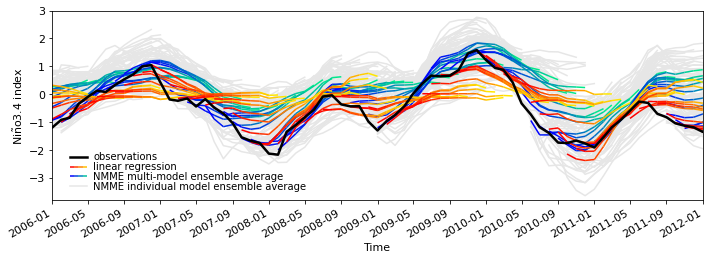

In [63]:
fcst_dates = test_period
    
rc_params = {'figure.figsize'      : (0.9*11.1, 3.75),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1.5,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    grey = [0.9,0.9,0.9]
    
    # Plot multi-model means -----
    for idx, date in enumerate(fcst_dates):
        to_plot = doppyo.utils.leadtime_to_datetime(mmm_nino34[anomaly_gp].sel(init_date=date))
        if idx == 0:
            plot_fcst(to_plot.time, to_plot, cmap='winter', 
                      **{'label':'NMME multi-model ensemble average'})
        else:
            plot_fcst(to_plot.time, to_plot, cmap='winter', 
                      **{'label':'_nolegend_'})

    # Plot regression(s) -----
    regr = 'linear regression'
    for idx, date in enumerate(fcst_dates):
        to_plot = doppyo.utils.leadtime_to_datetime(regr_nino34[regr][anomaly_gp].sel(init_date=date))
        if idx == 0:
            plot_fcst(to_plot.time, to_plot, cmap='autumn', 
                      **{'label':regr})
        else:
            plot_fcst(to_plot.time, to_plot, cmap='autumn', 
                      **{'label':'_nolegend_'})

    # Plot individual forecast members -----
    for idx, date in enumerate(fcst_dates):
        for idy, fcst in enumerate(fcst_nino34.values()):
            to_plot = doppyo.utils.leadtime_to_datetime(fcst[anomaly_gp].sel(init_date=date))
            if (idx == 0) & (idy == 0):
                plt.plot(to_plot.time.values, to_plot.mean('ensemble'),
                         color=grey, zorder=1, label='NMME individual model ensemble average')
            else:
                plt.plot(to_plot.time.values, to_plot.mean('ensemble'), 
                         color=grey, zorder=1, label='_nolegend_')

    obs_nino34[anomaly_gp].sel(lead_time=0).plot(color='k', linestyle='-', linewidth=linewidth+1, label='Observations')

#     plt.grid(True, which='both')
    plt.gca().set_axisbelow(True)
    
    # Manually make the legend -----
#     rect = mpl.patches.Rectangle((np.datetime64('2006-02'),-3.6), 20, 1.59, linewidth=0, facecolor='w', alpha=0.6,
#                                 capstyle='round', joinstyle='round')
#     plt.gca().add_patch(rect)
    
    span = pd.date_range('2006-03-01','2006-05-01', freq='15D')
    plt.plot(span, -3.3*np.ones_like(span.astype(int)), color=grey, zorder=1)
    plt.text(np.datetime64('2006-05-20'), -3.4, 'NMME individual model ensemble average', fontsize=fontsize-1)
    plot_fcst(span, -2.95*np.ones_like(span.astype(int)), cmap='winter')
    plt.text(np.datetime64('2006-05-20'), -3.05, 'NMME multi-model ensemble average', fontsize=fontsize-1)
    plot_fcst(span, -2.6*np.ones_like(span.astype(int)), cmap='autumn')
    plt.text(np.datetime64('2006-05-20'), -2.7, regr, fontsize=fontsize-1)
    plt.plot(span, -2.25*np.ones_like(span.astype(int)), color='k', linestyle='-', linewidth=linewidth+1)
    plt.text(np.datetime64('2006-05-20'), -2.35, 'observations', fontsize=fontsize-1)
    
    plt.xlim(np.datetime64('2006-01'),
             np.datetime64('2012-01'))
    plt.ylim(-3.8,3);
    plt.xlabel('Time');
    plt.ylabel(r'Ni$\tilde{\mathrm{n}}$o3.4 index');
    plt.title('')
    plt.xticks(pd.date_range(start='2006-01', end='2012-01', freq='4MS'),
               labels=[date.strftime('%Y-%m') for date in pd.date_range(start='2006-01', end='2012-01', freq='4MS')],
               rotation=30)
    

    plt.tight_layout();
    # plt.savefig(saveloc + 'nino34_timeseries.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'Fig1_timeseries.pdf', format='pdf', bbox_inches='tight')

# Let's get an appreciation of the absolute NMME skill by looking at the Gerrity (categorical) skill score and the mean squared skill score (MSSS)

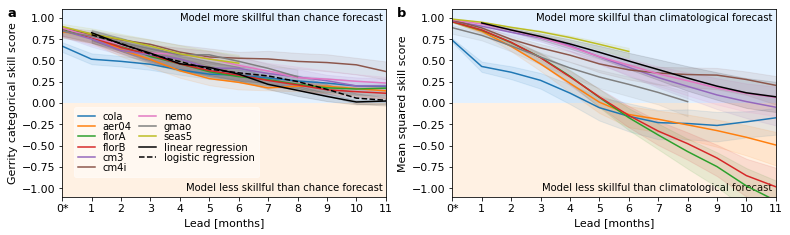

In [60]:
%%time
n_bootstraps = 1000
n_random_ensembles = len(fcst_nino34[list(fcst_nino34.keys())[0]].ensemble)
n_random_init_dates = len(fcst_nino34[list(fcst_nino34.keys())[0]].sel(init_date=test_period).init_date)
quantiles = [0.05, 0.95]

rc_params = {'figure.figsize'      : (11, 3.4),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1.7,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    axes = fig.subplots(nrows=1, ncols=2)

    # Pierce's score =============================================================
    ref = obs_where_event
    edges = [-np.inf, -0.5, 0.5, np.inf]

    col_n = 0
    for model_name, model in {**fcst_nino34, **regr_nino34}.items():
        ax0 = axes[0]     
        obs = ref[anomaly_gp].sel(init_date=test_period)
        fcst = model[anomaly_gp].sel(init_date=test_period)
        
        if 'linear regression' in model_name:
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=None, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst, obs, edges, edges, 'init_date')

            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, color='w', linestyle='--', zorder=2)
            if 'multi' in model_name:
                ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color='k', linestyle=':', zorder=2)
            else:
                ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color='k', linestyle='-', zorder=2)
        elif model_name == 'logistic regression':
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=None, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst, obs, edges, edges, 'init_date')
        
            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, linestyle='-', color='w', zorder=2)
            ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color='k', linestyle='--', zorder=2)
        else:
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=n_random_ensembles, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst.mean('ensemble'), obs, edges, edges, 'init_date')

            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color=colors[col_n],
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, color='w', zorder=2)
            ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color=colors[col_n], zorder=2)
            col_n+=1
        
        legend = ax0.legend(ncol=2, loc='lower left', bbox_to_anchor=[0.02,0.08,1,1], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
        ax0.set_xlim(0,11)
        ax0.set_xticks(np.arange(0,12))
        ax0.set_ylim(-1.1,1.1)
        ax0.set_ylabel("Gerrity categorical skill score")
        ax0.set_xlabel('Lead [months]')

    # Shade regions ------
    ymin, ymax = ax0.get_ylim()
    xmin, xmax = ax0.get_xlim()
    ax0.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax0.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
#     ax0.text(2.75,0.99,'Model more skillful than chance forecast', fontsize=fontsize-1)
#     ax0.text(3.00,-1.05,'Model less skillful than chance forecast', fontsize=fontsize-1)
    ax0.text(0.99, 0.98, 'Model more skillful than chance forecast', 
                transform=ax0.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax0.text(0.99, 0.02, 'Model less skillful than chance forecast', 
            transform=ax0.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    ax0.set_xticks(np.arange(0,12))
    ax0.set_xticklabels(['0*'] + np.arange(1,12).tolist())
    
    ax0.text(-0.17,0.96,'a',fontsize=label_fontsize,weight="bold",transform=ax0.transAxes)

    # MSSS ======================================================================
    # Climatological forecast -----
    reference_MSE = doppyo.skill.mean_squared_error(0, obs_nino34[anomaly_gp], over_dims='init_date')

    col_n = 0
    for model_name, model in {**fcst_nino34, **regr_nino34}.items():
        ax1 = axes[1]
        
        obs = obs_nino34[anomaly_gp].sel(init_date=test_period)
        fcst = model[anomaly_gp].sel(init_date=test_period)

        if model_name == 'logistic regression':
            pass
        elif 'linear regression' in model_name:
            MSSS_bootstrapped = bootstrap_skill_metric(
                fcst,
                obs,
                get_MSS_score,
                k=n_bootstraps,
                n=len(fcst.init_date),
                j=None, 
                skill_metric_kwargs={'reference_MSE': reference_MSE, 
                                     'over_dims': 'init_date'},
                with_dask=True)
            MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')
            
            ax1.fill_between(MSSS_bootstrapped. lead_time,
                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax1.plot(MSSS.lead_time, MSSS, label='__nolegend', linewidth=3, color='w', linestyle='--', zorder=2)
            if 'multi' in model_name:
                ax1.plot(MSSS.lead_time, MSSS, label=model_name, color='k', linestyle=':', zorder=2)
            else:
                ax1.plot(MSSS.lead_time, MSSS, label=model_name, color='k', linestyle='-', zorder=2)
        else:
            MSSS_bootstrapped = bootstrap_skill_metric(
                fcst,
                obs,
                get_MSS_score,
                k=n_bootstraps,
                n=len(fcst.init_date),
                j=n_random_ensembles, 
                skill_metric_kwargs={'reference_MSE': reference_MSE, 
                                     'over_dims': 'init_date'},
                with_dask=True)
            MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')
            
            ax1.fill_between(MSSS_bootstrapped. lead_time,
                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color=colors[col_n],
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax1.plot(MSSS.lead_time, MSSS, label='__nolegend', linewidth=3, color='w', zorder=2)
            ax1.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
            col_n+=1

    ax1.set_xlim(0,11)
    ax1.set_xticks(np.arange(0,12))
    ax1.set_ylim(-1.1,1.1)
    ax1.set_ylabel('Mean squared skill score')
    ax1.set_xlabel('Lead [months]')
    ax1.set_xticks(np.arange(0,12))
    ax1.set_xticklabels(['0*'] + np.arange(1,12).tolist())

    # Shade regions ------
    ymin, ymax = ax1.get_ylim()
    xmin, xmax = ax1.get_xlim()
    ax1.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax1.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
#     ax1.text(1.37,0.99,'Model more skillful than climatological forecast', fontsize=fontsize-1, zorder=0)
#     ax1.text(0.2,-1.05,'Model less skillful than climatological forecast', fontsize=fontsize-1, zorder=0)
    ax1.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
                transform=ax1.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax1.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
            transform=ax1.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    
    ax1.text(-0.17,0.96,'b',fontsize=label_fontsize,weight="bold",transform=ax1.transAxes)

    fig.tight_layout()
    # plt.savefig(saveloc + 'nino34_Gerrity_and_MSSS.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigB1_skill.pdf', format='pdf', bbox_inches='tight')

# Schematic showing the need for bias correction

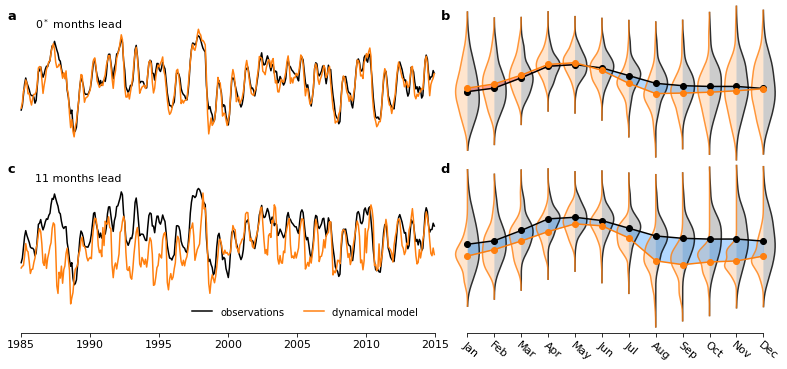

In [210]:
rc_params = {'figure.figsize'      : (13.3, 6),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : linewidth}

model = 'aer04'
obs = obs_nino34['full'].sel(init_date=full_period)
hcst = fcstm_nino34[model]['full'].sel(init_date=full_period).compute()
clim_period = slice('1985','2014')
plot_start = '1985'; plot_end = '2014'
model_color = colors[list(fcstm_nino34.keys()).index(model)]
stretch = 0.44
shift = 8
tail = 1.2
pos_bias_color = 'r'
neg_bias_color = upper
bias_alpha = 0.3
    
plot_period = slice(plot_start,plot_end)
with mpl.rc_context(rc=rc_params):
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.4, 1], 'wspace': 0.09})
    
    # Lead 0 --
    l = obs.sel(lead_time=0).sel(init_date=plot_period).plot(ax=ax1, color='k')
    l[0].set_clip_on(False)
    l = hcst.sel(lead_time=0).sel(init_date=plot_period).plot(ax=ax1, color=model_color)
    l[0].set_clip_on(False)
    
    obs_for_clim = obs.sel(lead_time=0).sel(init_date=clim_period)
    hcst_for_clim = hcst.sel(lead_time=0).sel(init_date=clim_period)

    obs_months = []; obs_means = []
    hcst_months = []; hcst_means = []
    ymin = []; ymax = []
    for obs_month, hcst_month in zip(list(obs_for_clim.groupby('init_date.month')),
                           list(hcst_for_clim.groupby('init_date.month'))):
        month = obs_month[0]
        obs_data = obs_month[1]
        hcst_data = hcst_month[1]
        
        global_min = min([obs_data.min().values, hcst_data.min().values])
        global_max = max([obs_data.max().values, hcst_data.max().values])
        ymax.append(global_max+tail)

         # Compute the ks-density -----
        y = np.linspace(global_min-tail,global_max+tail,1000)
        obs_kde = stats.gaussian_kde(obs_data.values)
        x = obs_kde(y) / max(obs_kde(y))
        f = plt.fill_betweenx(y=y, x1=month+stretch*x, x2=month, facecolor='k', alpha=0.2) 
        l = ax2.plot(month+stretch*x, y, linestyle='-', color='k', linewidth=linewidth, alpha=0.8)
        f.set_clip_on(False)
        l[0].set_clip_on(False)
        hcst_kde = stats.gaussian_kde(hcst_data.values)
        x = hcst_kde(y) / max(hcst_kde(y))
        f = plt.fill_betweenx(y=y, x1=month-stretch*x, x2=month, facecolor=model_color, alpha=0.2) 
        l = ax2.plot(month-stretch*x, y, linestyle='-', color=model_color, linewidth=linewidth, alpha=0.8)
        f.set_clip_on(False)
        l[0].set_clip_on(False)

        obs_mean = obs_data.values.mean()
        obs_means.append(obs_mean)
        obs_months.append(month)
        hcst_mean = hcst_data.values.mean()
        hcst_means.append(hcst_mean)
        hcst_months.append(month)

    hcst_means = np.array(hcst_means)
    obs_means = np.array(obs_means)
    
    l = ax2.plot(obs_months, obs_means, 'o-', color='k')
    l[0].set_clip_on(False)
    l = ax2.plot(hcst_months, hcst_means, 'o-', color=model_color)
    l[0].set_clip_on(False)
    ax2.fill_between(obs_months, obs_means, 
                     np.where(hcst_means>obs_means, hcst_means, np.nan), color=pos_bias_color, linewidth=0.0, alpha=bias_alpha)
    ax2.fill_between(obs_months, obs_means, 
                     np.where(hcst_means<=obs_means, hcst_means, np.nan), color=neg_bias_color, linewidth=0.0, alpha=bias_alpha)
    
    # Lead N --
    lead = 11
    l = (obs-shift).sel(lead_time=lead).shift(init_date=lead).sel(init_date=plot_period).plot(ax=ax1, color='k', label='observations')
    l[0].set_clip_on(False)
    l = (hcst-shift).sel(lead_time=lead).shift(init_date=lead).sel(init_date=plot_period).plot(ax=ax1, color=model_color, label='dynamical model')
    l[0].set_clip_on(False)
    
    obs_for_clim = (obs-shift).sel(lead_time=lead).shift(init_date=lead).sel(init_date=clim_period)
    hcst_for_clim = (hcst-shift).sel(lead_time=lead).shift(init_date=lead).sel(init_date=clim_period)
    
    obs_months = []; obs_means = []
    hcst_months = []; hcst_means = []
    for obs_month, hcst_month in zip(list(obs_for_clim.groupby('init_date.month')),
                           list(hcst_for_clim.groupby('init_date.month'))):
        month = obs_month[0]
        obs_data = obs_month[1]
        hcst_data = hcst_month[1]
        
        global_min = min([obs_data.min().values, hcst_data.min().values])
        global_max = max([obs_data.max().values, hcst_data.max().values])
        ymin.append(global_min-tail)
        
        # Compute the ks-density -----
        y = np.linspace(global_min-tail,global_max+tail,1000)
        obs_kde = stats.gaussian_kde(obs_data.values)
        x = obs_kde(y) / max(obs_kde(y))
        f = plt.fill_betweenx(y=y, x1=month+stretch*x, x2=month, facecolor='k', alpha=0.2) 
        l = ax2.plot(month+stretch*x, y, linestyle='-', color='k', linewidth=linewidth, alpha=0.8)
        f.set_clip_on(False)
        l[0].set_clip_on(False)
        hcst_kde = stats.gaussian_kde(hcst_data.values)
        x = hcst_kde(y) / max(hcst_kde(y))
        f = plt.fill_betweenx(y=y, x1=month-stretch*x, x2=month, facecolor=model_color, alpha=0.2) 
        l = ax2.plot(month-stretch*x, y, linestyle='-', color=model_color, linewidth=linewidth, alpha=0.8)
        f.set_clip_on(False)
        l[0].set_clip_on(False)

        obs_mean = obs_data.values.mean()
        obs_means.append(obs_mean)
        obs_months.append(month)
        hcst_mean = hcst_data.values.mean()
        hcst_means.append(hcst_mean)
        hcst_months.append(month)
 
    ylims = (min(ymin)-0.3, max(ymax))
    hcst_means = np.array(hcst_means)
    obs_means = np.array(obs_means)
    
    l = ax2.plot(obs_months, obs_means, 'o-', color='k')
    l[0].set_clip_on(False)
    l = ax2.plot(hcst_months, hcst_means, 'o-', color=model_color)
    l[0].set_clip_on(False)
    ax2.fill_between(obs_months, obs_means, 
                     np.where(hcst_means>obs_means, hcst_means, np.nan), color=pos_bias_color, linewidth=0.0, alpha=bias_alpha)
    ax2.fill_between(obs_months, obs_means, 
                     np.where(hcst_means<=obs_means, hcst_means, np.nan), color=neg_bias_color, linewidth=0.0, alpha=bias_alpha)
    
    ax1.set_xlim(np.datetime64(plot_start),np.datetime64(plot_end)+1)
    ax1.set_ylim(*ylims)
    ax1.set_title('')
    ax1.set_ylabel('')
    #ax1.set_frame_on(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_yticks([])
    ax1.set_xticks([str(year) for year in range(int(plot_start), int(plot_end)+2, 5)])
    ax1.set_xticklabels(['1985','','1995','','2005','','2015'], rotation=0, ha='center')
#     ax1.tick_params(axis='x', rotation=0, ha="left")
#     ax1.xaxis.get_majorticklabels().set_horizontalalignment("left")
    ax1.set_xlabel('')
    ax1.text(np.datetime64(plot_start)+1,29.7,'0$^*$ months lead')
    ax1.text(np.datetime64(plot_start)+1,29.7-shift,f'{lead} months lead')
    ax1.legend(ncol=2, loc='lower right', frameon=False, bbox_to_anchor=[0,0.02,0.98,0.97])
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax2.set_ylim(*ylims)
    ax2.set_xlim(1-stretch-0.1, 12+stretch+0.1)
    ax2.set_xticks(range(1,13))
    ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                        rotation=-40, ha='left', rotation_mode="anchor")
#     ax2.set_frame_on(False)
#     ax2.axes.get_yaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticks([])
    ax2.set_xlabel('')
    ax2.set_xlim(1,12)
    
    # Add figure labels
    ax1.text(np.datetime64(plot_start)-1,30.2,'a',fontsize=label_fontsize,weight="bold")
    ax1.text(np.datetime64(plot_start)-1,30.2-shift,'c',fontsize=label_fontsize,weight="bold")
    ax2.text(0,30.2,'b',fontsize=label_fontsize,weight="bold")
    ax2.text(0,30.2-shift,'d',fontsize=label_fontsize,weight="bold")
    
    plt.savefig(saveloc + 'FigB2_bias.pdf', format='pdf', bbox_inches='tight')

### Can we make a schematic showing the different types of anomaly calculation?

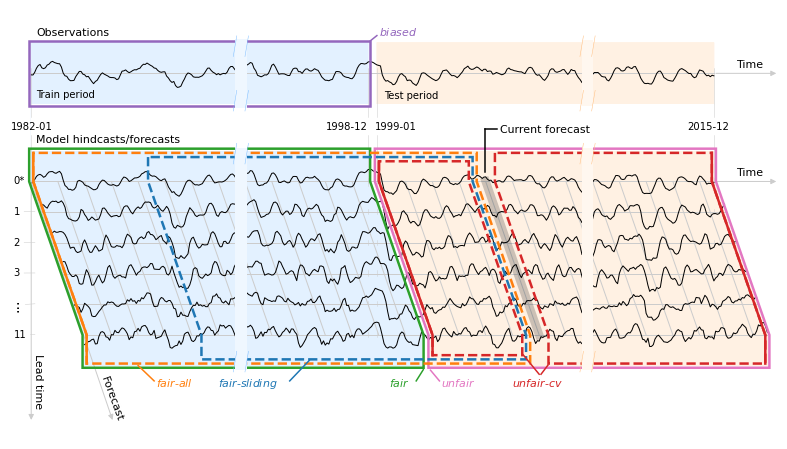

In [62]:
rc_params = {'figure.figsize'      : (13.8, 8),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    grey = [0.8,0.8,0.8]
    border_linewidth = linewidth+1
    
    leads = [0,1,2,3,6,11]
    shift = 6
    clip_ends = 4

    obs = obs_nino34['full'].sel(init_date=full_period, lead_time=0).rename({'init_date':'time'})
    hcst = cm4_nino34['full'].sel(init_date=full_period).mean('ensemble').compute()

    obs_plot = obs[:-len(leads)*clip_ends]+2.5*shift
    time_plot = obs_plot.time
    min_time = time_plot.min().values
    max_time = time_plot.max().values
    plt.plot(time_plot,obs_plot,color='k', linewidth=linewidth-0.5)
    plt.plot([min_time, max_time],[obs_plot.mean('time'), obs_plot.mean('time')], color=grey, zorder=0, linewidth=linewidth-0.5)
    ax.annotate("", xy=(mdates.date2num(max_time)+1100, obs_plot.mean('time')), xycoords='data',
                            xytext=(mdates.date2num(max_time), obs_plot.mean('time')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
    plt.text(doppyo.sugar.month_delta(max_time, 13), obs_plot.mean('time')+1.1, 'Time', fontsize=fontsize)

    # Patch vertices -----
    hcst_span = 189
    gap = 5
    v1_s = [[mdates.date2num(min_time), obs_plot.mean('time').values+shift]]
    v1_e = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span)), obs_plot.mean('time').values+shift]]
    v2_s = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span+gap)), obs_plot.mean('time').values+shift]]
    v2_e = [[mdates.date2num(max_time), obs_plot.mean('time').values+shift]]

    # Anomaly boxes -----
    adj_x = 35 #22
    adj_y = 0.41 #0.25
    c0 = [[mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values-shift-adj_y], 
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values-shift-adj_y],
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values+shift+adj_y], 
          [mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values+shift+adj_y]]
    c3a = [[mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values-shift+adj_y], 
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values-shift+adj_y],
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values+shift-adj_y], 
          [mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values+shift-adj_y]]

    for idx, lead in enumerate(leads):
        if idx == 0:
            hcst_plot = (hcst.sel(lead_time=lead)-(idx+1)*shift)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
            first_mean = hcst_plot.mean('init_date')
        else:
            hcst_plot = hcst.sel(lead_time=lead)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
            hcst_plot = hcst_plot - hcst_plot.mean('init_date') + first_mean - idx*shift

        time_plot = [doppyo.sugar.month_delta(date, idx*2) for date in hcst_plot.init_date.values]

        plt.plot(time_plot, hcst_plot, color='k', linewidth=linewidth-0.5)
        plt.plot([min(time_plot), max(time_plot)],[hcst_plot.mean('init_date'), hcst_plot.mean('init_date')], color=grey, zorder=0, linewidth=linewidth-0.5)
        if idx == 0:
            ax.annotate("", xy=(mdates.date2num(max(time_plot))+1100, hcst_plot.mean('init_date')), xycoords='data',
                            xytext=(mdates.date2num(max(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(max(time_plot),13), hcst_plot.mean('init_date')+1.1, 'Time', fontsize=fontsize)
            ax.annotate("", xy=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')-47), xycoords='data',
                            xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(min(time_plot),1), hcst_plot.mean('init_date')-len(leads)*shift-8, 'Lead time', rotation=-90, fontsize=fontsize)
            ax.annotate("", xy=(mdates.date2num(min(time_plot))+1400, hcst_plot.mean('init_date')-47), xycoords='data',
                            xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(min(time_plot),38), hcst_plot.mean('init_date')-len(leads)*shift-10.7, 'Forecast', rotation=-70, fontsize=fontsize)

            # Make grid -----
            step = 15
            count=0
            for s in np.arange(step, 390, step):
                plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                         [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color=grey, zorder=1, linewidth=linewidth-0.5)
                if count == 16:
                    plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                         [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color='k', zorder=2, linewidth=linewidth+7, linestyle='-', alpha=0.2)
                count+=1
            v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values+shift])
            v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values+shift])
            v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values+shift])
            v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values+shift])

        # Patch vertices -----
        v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values])
        v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values])
        v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values])
        v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values])
        if idx == len(leads)-1:
            time_extra = min(time_plot) #doppyo.sugar.month_delta(min(time_plot),lead+(leads[1]-leads[0]))
            v1_s.append([mdates.date2num(time_extra), hcst_plot.mean('init_date').values-shift])
            v1_e.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span)), hcst_plot.mean('init_date').values-shift])
            v2_s.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span+gap)), hcst_plot.mean('init_date').values-shift])
            v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values-shift])

    v1 = v1_s + v1_e[::-1]
    v2 = v2_s + v2_e[::-1]
    pgon1 = plt.Polygon(v1, color=upper_color, zorder=0)
    pgon2 = plt.Polygon(v2, color=lower_color, zorder=0)
    ax.add_patch(pgon1)
    ax.add_patch(pgon2)

    vw = [[mdates.date2num(min_time)-1,27],[mdates.date2num(max_time)+1,27],
          [mdates.date2num(max_time)+1,36],[mdates.date2num(min_time)-1,36]]
    pgonw = plt.Polygon(vw, color='w', zorder=0)
    ax.add_patch(pgonw)

    # Anomaly boxes -----
    pgonc0 = plt.Polygon(c0, edgecolor=colors[4], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc0)
    c1 = [[v[0]+0*adj_x, v[1]] for v in v2_s[1:]] + v2_e[1:][::-1]
    v_tmp = v2_e[1:][::-1]
    c1 = [[v[0]-1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]+1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]-1*adj_y]]] + \
            [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
    pgonc1 = plt.Polygon(c1, edgecolor=colors[6], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc1)
    v_tmp = v1_e[1:][::-1]
    c2 = [[v[0]-1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]+1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]-1*adj_y]]] + \
            [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
    pgonc2 = plt.Polygon(c2, edgecolor=colors[2], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc2)
#     pgonc3a = plt.Polygon(c3a, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
#     ax.add_patch(pgonc3a)
#     v_tmp = v1_e[1:3] + [[v1_e[1][0],v1_e[-1][1]]]
#     c3b = [[v[0]+1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+1*adj_y]]] + \
#             [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]][::-1]
#     pgonc3b = plt.Polygon(c3b, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
#     ax.add_patch(pgonc3b)

    v_tmp = v1_e[1:][::-1]
    slide = 1890
    cs = [[v[0]+3*adj_x+slide, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-3*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+3*adj_y]]] + \
            [[v[0]-3*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+3*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-3*adj_y]]]
    pgoncs = plt.Polygon(cs, edgecolor=colors[0], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgoncs)

    ca = [[v[0]+1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+1*adj_y]]] + \
            [[v[0]-1*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
    pgonca = plt.Polygon(ca, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgonca)
    c_solid = ca[0:8]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[1], linewidth=border_linewidth, zorder=11)


    v_tmp = v2_e[1:][::-1]
    c1cva = [[v[0]+1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-5*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+5*adj_y]]] + \
            [[v[0]-5*adj_x-(5900-slide), v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+5*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-5*adj_y]]]
    pgonc1cva = plt.Polygon(c1cva, edgecolor=colors[3], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    c_solid = c1cva[0:8]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[3], linewidth=border_linewidth, zorder=11)
    ax.add_patch(pgonc1cva)
    c1cvb = [[v[0]+1*adj_x+1980, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+1*adj_y]]] + \
            [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
    pgonc1cvb = plt.Polygon(c1cvb, edgecolor=colors[3], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgonc1cvb)
    c_solid = c1cvb[-8:]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[3], linewidth=border_linewidth, zorder=11)

    ax.set_ylim(-30,55)
    ax.set_xlim(np.datetime64('1981'),np.datetime64('2017'))
    ax.text(mdates.date2num(min_time)+80, 49.3, 'Observations',fontsize=fontsize)
    ax.text(mdates.date2num(min_time)+80, 28.4, 'Model hindcasts/forecasts',fontsize=fontsize)
    ax.text(doppyo.sugar.month_delta(min_time,hcst_span-186), 37.3, 'Train period',fontsize=fontsize-1)
    ax.text(doppyo.sugar.month_delta(max_time,-185), 37.1, 'Test period',fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+8000, 30.4, 'Current forecast',fontsize=fontsize, zorder=11)
    plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7750), (22.8,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')
    plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7950), (31.2,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')

    # Add breaks -----
    start = mdates.date2num(min_time)+3480
    width = 200
    height = 2.7
    offset = 0.5
    slant = 30
    col = ((9*upper_color - 8) + 1) / 2
    col_fill = ((9*upper_color - 8) + 15) / 16
    vb1 = [[start,-15.9],[start+width,-15.9],
          [start+width,48.8],[start,48.8]]
    pgonb1 = plt.Polygon(vb1, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
    ax.add_patch(pgonb1)
    vw1 = [[start,27.5],[start+width,27.5],
          [start+width,35.3],[start,35.3]]
    pgonw1 = plt.Polygon(vw1, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
    ax.add_patch(pgonw1)
    plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

    start = mdates.date2num(min_time)+9400
    col = ((9*lower_color - 8) + 1) / 2
    col_fill = ((9*lower_color - 8) + 15) / 16
    vb2 = [[start,-15.9],[start+width,-15.9],
          [start+width,48.5],[start,48.5]]
    pgonb2 = plt.Polygon(vb2, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
    ax.add_patch(pgonb2)
    vw2 = [[start,27.5],[start+width,27.5],
          [start+width,35.6],[start,35.6]]
    pgonw2 = plt.Polygon(vw2, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
    ax.add_patch(pgonw2)
    plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

    # Add dates -----
    yloc = 31
    ax.text(mdates.date2num(min_time)-350, yloc, '1982-01', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+5030, yloc, '1998-12', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+5870, yloc, '1999-01', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+11200, yloc, '2015-12', fontsize=fontsize-1)

    # Add lead time ticks -----
    straighten = 0.6
    base = 21
    ticks = ['0*','1','2','3','...','11']
    for idx, tick in enumerate(ticks):
        if tick == '...':
            ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data', rotation=90,fontsize=fontsize+3,
                        xytext=(mdates.date2num(min_time)-410, base-idx*shift-1.7*straighten), textcoords='data',
                        arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))
        else:        
            ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data',fontsize=fontsize-1,
                        xytext=(mdates.date2num(min_time)-300, base-idx*shift-straighten), textcoords='data',
                        arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))

    # Legend -----
    plt.plot((doppyo.sugar.month_delta(min_time,166+24), doppyo.sugar.month_delta(min_time,170+24)),
             (48.3,49.4), color=colors[4], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,170+25), 49.4, '$biased$', fontsize=fontsize, color=colors[4])

    plt.plot((doppyo.sugar.month_delta(min_time,240-16), doppyo.sugar.month_delta(min_time,245-16)),
             (-16.0,-18.1), color=colors[6], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,246-16), -19.3, '$unfair$', fontsize=fontsize, color=colors[6])

    plt.plot((doppyo.sugar.month_delta(min_time,240+36), doppyo.sugar.month_delta(min_time,245+40)),
             (-13.0,-16.8), color=colors[3], linewidth=linewidth, zorder=20)
    plt.plot((doppyo.sugar.month_delta(min_time,245+45), doppyo.sugar.month_delta(min_time,240+46)),
             (-15.0,-16.8), color=colors[3], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,246+24), -19.3, '$unfair$-$cv$', fontsize=fontsize, color=colors[3])

    plt.plot((doppyo.sugar.month_delta(min_time,235-15), doppyo.sugar.month_delta(min_time,231-15)),
             (-15.9,-18.1), color=colors[2], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,221-20), -19.3, '$fair$', fontsize=fontsize, color=colors[2])

#     plt.plot((doppyo.sugar.month_delta(min_time,164+24), doppyo.sugar.month_delta(min_time,169+13)),
#              (-14.9,-18.1), color=colors[1], linewidth=linewidth, zorder=20)
#     ax.text(doppyo.sugar.month_delta(min_time,169-6), -19.3, '$fair*$', fontsize=fontsize, color=colors[1])
#     plt.plot((doppyo.sugar.month_delta(min_time,147+18), doppyo.sugar.month_delta(min_time,155+18)),
#              (47.8,49.4), color=colors[1], linewidth=linewidth, zorder=20)
#     ax.text(doppyo.sugar.month_delta(min_time,155+19), 49.4, '$fair*$', fontsize=fontsize, color=colors[1])

    plt.plot((doppyo.sugar.month_delta(min_time,164-8), doppyo.sugar.month_delta(min_time,164-19)),
             (-14.1,-18.1), color=colors[0], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,165-60), -19.3, '$fair$-$sliding$', fontsize=fontsize, color=colors[0])

    plt.plot((doppyo.sugar.month_delta(min_time,104-44), doppyo.sugar.month_delta(min_time,104-35)),
             (-15.1,-18.1), color=colors[1], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,165-95), -19.3, '$fair$-$all$', fontsize=fontsize, color=colors[1])

    # plt.plot((doppyo.sugar.month_delta(min_time,90), doppyo.sugar.month_delta(min_time,90)),
    #          (33.5,35.5), color=colors[0], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,85), 31, 'C0', fontsize=fontsize, color=colors[0])
    # plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
    #          (33.5,36.4), color=colors[3], linewidth=linewidth, zorder=20)
    # plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
    #          (27,30), color=colors[3], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,105), 31, 'C3', fontsize=fontsize, color=colors[3])
    # plt.plot((doppyo.sugar.month_delta(min_time,130), doppyo.sugar.month_delta(min_time,130)),
    #          (27.5,30), color=colors[2], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,125), 31, 'C2', fontsize=fontsize, color=colors[2])
    # plt.plot((doppyo.sugar.month_delta(min_time,205), doppyo.sugar.month_delta(min_time,205)),
    #          (27.3,30), color=colors[1], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,200), 31, 'C1', fontsize=fontsize, color=colors[1])

    plt.plot((min_time, min_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((min_time, min_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    # for tick in np.arange(len(leads)):
    #     plt.plot((min_time, min_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (20,30), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (33.5,43), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), 
                 (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (20,30), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (33.5,43), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), 
                 (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((max_time, max_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((max_time, max_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((max_time, max_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')

    ax.axis('off');
    # plt.savefig(saveloc + 'anomaly_schematic.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigB3_methods.pdf', format='pdf', bbox_inches='tight')

# Can we see a step change in the error around 1999

In [211]:
er_nino34 = {fcst_name: (fcst.mean('ensemble') - obs_nino34) for fcst_name, fcst in fcst_nino34.items()}

cola: null hypothesis rejected at a p-value of 0.01
aer04: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
florA: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
florB: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
cm3: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
cm4i: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
nemo: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical
gmao: null hypothesis rejected at a p-value of 0.01
seas5: cannot reject null hypothesis, at a p-value of 0.01, that distributions are identical


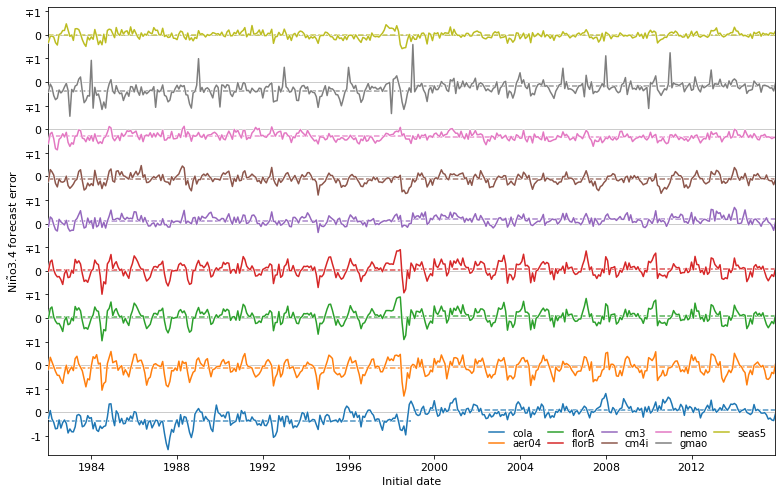

In [222]:
lead = 0
anom = 'full'
KS_pvalue = 0.01

rc_params = {'figure.figsize'      : (11.0, 7),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1.5,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    grey = [0.8,0.8,0.8]
    
    col_n = 0
    for er_name, er in er_nino34.items(): 
        to_plot = er[anom].sel(lead_time=lead)
        plt.plot([np.datetime64('1960'),np.datetime64('2018')],[2*col_n, 2*col_n], color=grey, linewidth=linewidth-0.5)
        plt.plot(to_plot.init_date, to_plot+col_n*2, color='w', linewidth=linewidth+1, label='_nolegend_', zorder=10)
        plt.plot(to_plot.init_date, to_plot+col_n*2, color=colors[col_n], label=er_name, zorder=10)
        
        pre = to_plot.sel(init_date=slice('1982','1998'))
        plt.plot([pre.init_date.values[0], pre.init_date.values[-1]], 
                 [pre.mean('init_date')+col_n*2, pre.mean('init_date')+col_n*2], 
                 color=colors[col_n], 
                 linestyle='--', alpha=0.8, label='_nolegend_')
#         plt.fill_between([pre.init_date.values[0], pre.init_date.values[-1]],
#                          [0+col_n*2, 0+col_n*2],
#                          [pre.mean('init_date')+col_n*2, pre.mean('init_date')+col_n*2], color=colors[col_n], alpha=0.2)
        post = to_plot.sel(init_date=slice('1999','2015'))
        plt.plot([post.init_date.values[0], post.init_date.values[-1]], 
                 [post.mean('init_date')+col_n*2, post.mean('init_date')+col_n*2], 
                 color=colors[col_n], 
                 linestyle='--', alpha=0.8, label='_nolegend_')
#         plt.fill_between([post.init_date.values[0], post.init_date.values[-1]],
#                          [0+col_n*2, 0+col_n*2],
#                          [post.mean('init_date')+col_n*2, post.mean('init_date')+col_n*2], color=colors[col_n], alpha=0.2)
        col_n += 1
    
        # Compute the Kolmogorov-Smirnov statistic on pre and post samples -----
        D_KS, p_KS = scipy.stats.ks_2samp(pre, post)
        if (p_KS > KS_pvalue):
            print(er_name + ': cannot reject null hypothesis, at a p-value of ' + str(KS_pvalue) + ', that distributions are identical')
        else: 
            print(er_name + ': null hypothesis rejected at a p-value of ' + str(KS_pvalue))
            
    plt.yticks(np.arange(-2,2*col_n+1,1), [-2,-1,0] + ['$\mp$1',0]*len(er_nino34))
    plt.xlim(np.datetime64(full_period[0]),
             np.datetime64(full_period[-1]))
    plt.ylim(-1.8,1.2+2*(col_n-1))
    plt.xlabel('Initial date')
    plt.ylabel(r'Ni$\tilde{\mathrm{n}}$o3.4 forecast error')
    
    legend = plt.legend(ncol=5, fontsize=fontsize-1, loc='lower right', bbox_to_anchor=[0.02,-0.005,0.98,0.5], framealpha=0.5)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    
    fig.tight_layout()
    # plt.savefig(saveloc + 'nino34_full_error_timeseries.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigS_error.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to linear regression for each of the different anomaly types?

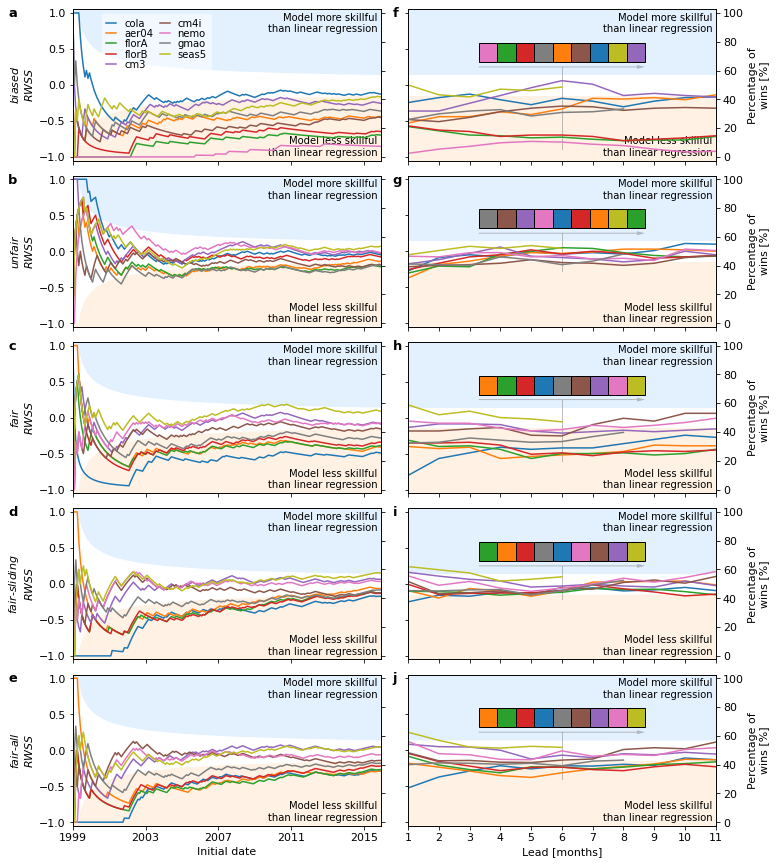

In [65]:
rc_params = {'figure.figsize'      : (9.5, 2.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.6,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0,4.4,0.45,1],[0,3.3,0.45,1],[0,2.2,0.45,1],[0,1.1,0.45,1],[0,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    lead = 3
    order_lead=6
    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    label = ['a','b','c','d','e']
    base = regr_nino34['linear regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in fcst_nino34.items():
            if 'ensemble' in model.dims:
                sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                   model[anom].mean('ensemble').sel(init_date=test_period), 
                                                   obs_nino34[anom].sel(init_date=test_period))
            else:
                sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                   model[anom].sel(init_date=test_period), 
                                                   obs_nino34[anom].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])

            col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, loc='upper left', bbox_to_anchor=[0.08,0.00,1,1], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        ax.set_ylim(-1.05, 1.05)
#         if (idx == 0) | (idx == 2):
        anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))
        ax.set_ylabel('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$')+'\n$RWSS$')
#         if (idx == 1) | (idx == 3) | (idx == 4):
#             ax.set_yticklabels([])
        ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
        if idx == 4:
            ax.set_xlabel('Initial date')
            ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
        else:
            ax.set_xticklabels([])
        ax.set_xlim(np.datetime64(test_period[0]),
                    np.datetime64(test_period[-1]))
        anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels([])
#         if (idx == 1) | (idx == 4):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
#             ax2.set_ylabel('Percentage of wins [%]')
#         if (idx == 0) | (idx == 2) | (idx == 3):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(0.99, 0.98, 'Model more skillful\nthan linear regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
        ax.text(0.99, 0.02, 'Model less skillful\nthan linear regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
        
        ax.text(-0.21,0.95,label[idx],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
        
    # RH column ------
    axes_locs = [[0.49,4.4,0.45,1],[0.49,3.3,0.45,1],[0.49,2.2,0.45,1],[0.49,1.1,0.45,1],[0.49,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    label = ['f','g','h','i','j']
    base = regr_nino34['linear regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        order_based_on = []
        for idm, (model_name, model) in enumerate(fcst_nino34.items()):
            if 'ensemble' in model.dims:
                sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                    model[anom].mean('ensemble').sel(init_date=test_period), 
                                                    obs_nino34[anom].sel(init_date=test_period))
            else:
                sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                    model[anom].sel(init_date=test_period), 
                                                    obs_nino34[anom].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')
            
            if 'ensemble' in model.dims:
                order_based_on.append(-(sign / norm).sel(init_date=test_period[-1]).sel(lead_time=order_lead).values)

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])
            
            col_n += 1
        order = np.argsort(order_based_on)
        
        # Create a Rectangle patch
        for ido, o in enumerate(order):
            rect = mpl.patches.Rectangle(((0.6*ido)+3.3,0.32),0.6,0.26,linewidth=linewidth-0.5,facecolor=colors[o], edgecolor='k', clip_on=False)
            ax.add_patch(rect)
#             if idx == 0:
#                 ax.text(ido+0.35,0.67, list(fcst_nino34.keys())[o], fontsize=11)
        ax.plot([6,6],[min(order_based_on)-0.09, 0.25], color='grey', linewidth=linewidth-0.5,zorder=1, alpha=0.5)
        arrow_properties = dict(
            facecolor="grey", width=1, headlength=8,
            headwidth=4, alpha=0.5, edgecolor='None')
        ax.annotate(
            "", xy=(8.7, 0.25),
            xytext=(3.3, 0.25),
            arrowprops=arrow_properties)
#         ax.text(9, 0.22, 'Skill', fontsize=11, color='grey', alpha=0.5)

#         if idx == 0:
#             legend = ax.legend(ncol=3, fontsize=11, loc='upper left', bbox_to_anchor=[0.00,0.00,1,1], framealpha=0.5)
#             legend.get_frame().set_facecolor('w')
#             legend.get_frame().set_edgecolor('w')

        # Adjust y-axes limits to be symmetric -----
        ymin, ymax = ax.get_ylim()
        ylim = max([abs(ymin), abs(ymax)])
        ax.set_ylim(-1.05, 1.05)
        ax.set_xticks(np.arange(0,12))
        ax.set_xlim(1,11)
#         if (idx == 0) | (idx == 2):
#             ax.set_ylabel('Final random walk skill score')
#         if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
        if idx == 4:
            ax.set_xlabel('Lead [months]')
        else:
            ax.set_xticklabels([])
#         anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
#         if (idx == 1) | (idx == 4):
        ticks = np.arange(0,1.1,0.2)
        ax2.set_yticks(ticks)
        ax2.set_yticklabels([int(100*t) if int(10*t)%2==0 else '' for t in ticks])
        ax2.set_ylabel('Percentage of\nwins [%]')
#         if (idx == 0) | (idx == 2) | (idx == 3):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
#         ax.text(1.2,0.79,'Model more skillful than \nlinear regression', fontsize=11, zorder=0)
#         ax.text(1.2,-0.96,'Model less skillful than \nlinear regression', fontsize=11, zorder=0)
        ax.text(0.99, 0.98, 'Model more skillful\nthan linear regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
        ax.text(0.99, 0.02, 'Model less skillful\nthan linear regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
        
        ax.text(-0.05,0.95,label[idx],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

    # plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3_and_integral.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'Fig2_RWSSlin.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to logistic regression for each of the different anomaly types?
Note in previous versions of the notebook, there was a minor error in the way the observation fair-sliding and fair-all anomalies were constructed resulting in missing data at the first and last initial dates. This has been corrected

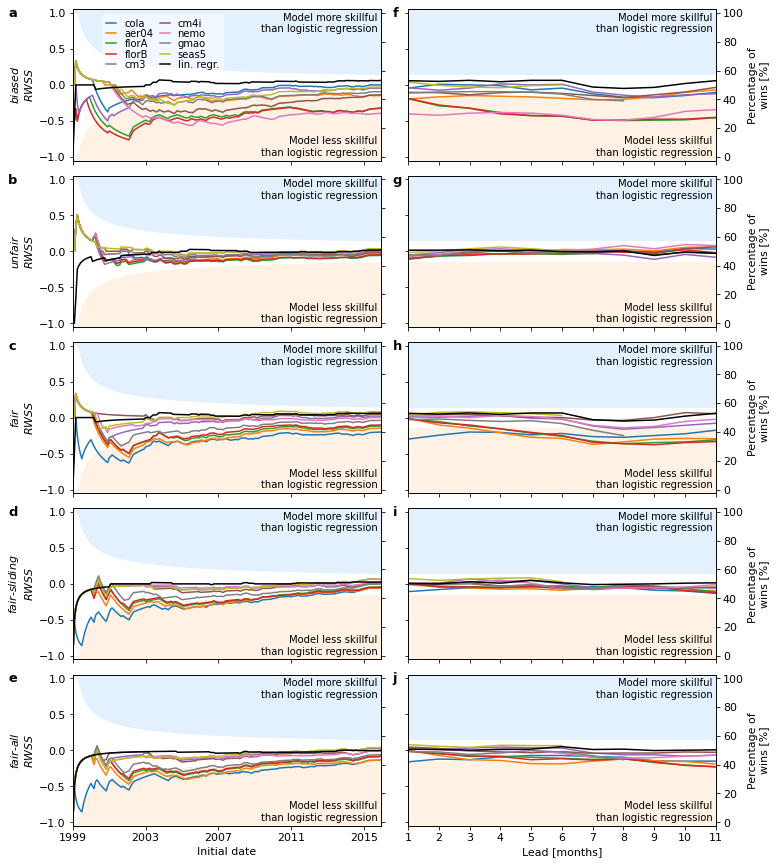

In [91]:
rc_params = {'figure.figsize'      : (9.5, 2.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.6,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0,4.4,0.45,1],[0,3.3,0.45,1],[0,2.2,0.45,1],[0,1.1,0.45,1],[0,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    lead = 3
    order_lead=6
    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    label = ['a','b','c','d','e']
    base = regr_nino34['logistic regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in {**fcst_where_event, 
                                  **{'linear regression':regr_where_event['linear regression']}}.items():
            sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                model[anom].sel(init_date=test_period), 
                                                obs_where_event[anom].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color='w', label='_nolegend_')
            if model_name == 'linear regression':
                ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label='lin. regr.', color='k', linestyle='-')
            elif model_name == 'multi-linear regression':
                ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label='m.-lin. regr.', color='k', linestyle='--')
            else:
                ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, loc='upper left', bbox_to_anchor=[0.08,0.00,1,1], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        ax.set_ylim(-1.05, 1.05)
#         if (idx == 0) | (idx == 2):
        anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))
        ax.set_ylabel('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$')+'\n$RWSS$')
#         if (idx == 1) | (idx == 3) | (idx == 4):
#             ax.set_yticklabels([])
        ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
        if idx == 4:
            ax.set_xlabel('Initial date')
            ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
        else:
            ax.set_xticklabels([])
        ax.set_xlim(np.datetime64(test_period[0]),
                    np.datetime64(test_period[-1]))
        anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels([])
#         if (idx == 1) | (idx == 4):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
#             ax2.set_ylabel('Percentage of wins [%]')
#         if (idx == 0) | (idx == 2) | (idx == 3):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(0.99, 0.98, 'Model more skillful\nthan logistic regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
        ax.text(0.99, 0.02, 'Model less skillful\nthan logistic regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
        
        ax.text(-0.21,0.95,label[idx],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
        
    # RH column ------
    axes_locs = [[0.49,4.4,0.45,1],[0.49,3.3,0.45,1],[0.49,2.2,0.45,1],[0.49,1.1,0.45,1],[0.49,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    label = ['f','g','h','i','j']
    base = regr_nino34['logistic regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        order_based_on = []
        for idm, (model_name, model) in enumerate({**fcst_where_event, 
                                                   **{'linear regression':regr_where_event['linear regression']}}.items()):
            sign_test = doppyo.skill.sign_test(base[anom].sel(init_date=test_period), 
                                                model[anom].sel(init_date=test_period), 
                                                obs_where_event[anom].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            if model_name == 'linear regression':
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), label='lin. regr.', color='k', linestyle='-')
            elif model_name == 'multi-linear regression':
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), label='m.-lin. regr.', color='k', linestyle='--')
            else:
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])
                col_n += 1

        order = np.argsort(order_based_on)
        
        # Create a Rectangle patch
#         for ido, o in enumerate(order):
#             rect = mpl.patches.Rectangle(((0.6*ido)+3.3,0.32),0.6,0.26,linewidth=linewidth-0.5,facecolor=colors[o], edgecolor='k', clip_on=False)
#             ax.add_patch(rect)
# #             if idx == 0:
# #                 ax.text(ido+0.35,0.67, list(fcst_nino34.keys())[o], fontsize=11)
#         ax.plot([6,6],[min(order_based_on)-0.09, 0.25], color='grey', linewidth=linewidth-0.5,zorder=1, alpha=0.5)
#         arrow_properties = dict(
#             facecolor="grey", width=1, headlength=8,
#             headwidth=4, alpha=0.5, edgecolor='None')
#         ax.annotate(
#             "", xy=(8.7, 0.25),
#             xytext=(3.3, 0.25),
#             arrowprops=arrow_properties)
# #         ax.text(9, 0.22, 'Skill', fontsize=11, color='grey', alpha=0.5)

#         if idx == 0:
#             legend = ax.legend(ncol=3, fontsize=11, loc='upper left', bbox_to_anchor=[0.00,0.00,1,1], framealpha=0.5)
#             legend.get_frame().set_facecolor('w')
#             legend.get_frame().set_edgecolor('w')

        # Adjust y-axes limits to be symmetric -----
        ymin, ymax = ax.get_ylim()
        ylim = max([abs(ymin), abs(ymax)])
        ax.set_ylim(-1.05, 1.05)
        ax.set_xticks(np.arange(0,12))
        ax.set_xlim(1,11)
#         if (idx == 0) | (idx == 2):
#             ax.set_ylabel('Final random walk skill score')
#         if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
        if idx == 4:
            ax.set_xlabel('Lead [months]')
        else:
            ax.set_xticklabels([])
#         anom_split = anom.split('-')
#         ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
#         if (idx == 1) | (idx == 4):
        ticks = np.arange(0,1.1,0.2)
        ax2.set_yticks(ticks)
        ax2.set_yticklabels([int(100*t) if int(10*t)%2==0 else '' for t in ticks])
        ax2.set_ylabel('Percentage of\nwins [%]')
#         if (idx == 0) | (idx == 2) | (idx == 3):
#             ax2.set_yticks(np.arange(0,1.1,0.1))
#             ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
#         ax.text(1.2,0.79,'Model more skillful than \nlinear regression', fontsize=11, zorder=0)
#         ax.text(1.2,-0.96,'Model less skillful than \nlinear regression', fontsize=11, zorder=0)
        ax.text(0.99, 0.98, 'Model more skillful\nthan logistic regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
        ax.text(0.99, 0.02, 'Model less skillful\nthan logistic regression', 
                transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
        
        ax.text(-0.05,0.95,label[idx],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

    # plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3_and_integral.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigS_RWSSlog.pdf', format='pdf', bbox_inches='tight')

# How do the model **unfair** anomalies compare when assessed relative to observed **fair** anomalies?

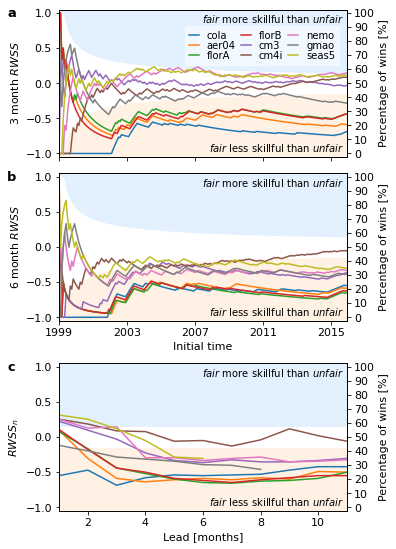

In [106]:
rc_params = {'figure.figsize'      : (4, 4.55),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.5,
             'legend.labelspacing' : 0.01,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()
    axes_locs = [[0,1,1,0.45],[0,0.5,1,0.45],[0,-0.08,1,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('unfair',anomaly_gp)] #, ('unfair-cv:7yr',anomaly_gp)]
    labels = ['a','b','c','d','e','f']
    # models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    # model_name = ['cola','aer04','florA','florB','cm3','cm4']

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                   model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                   obs_nino34[anomaly_gp].sel(init_date=test_period))
                sign = sign_test['sign_test']
                conf = sign_test['confidence']
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color='w', label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(test_period[0],
                            test_period[-1])
                ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
                ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
                if axI ==1:
                    ax.set_xlabel('Initial time')
                else:
                    ax.set_xticklabels([])
                    
                ax.set_ylabel(f'{str(lead)} month $RWSS$')
                    
                if (model_name == 'cola'):
                    ax.text(-0.18,0.95,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(-0.025, 1.025)
                if (model_name == 'cola'):
                    ax2.set_yticks(np.arange(0,1.1,0.1))
                    ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
                    ax2.set_ylabel('Percentage of wins [%]')
                else:
                    ax2.set_yticks([])

                ax.set_ylim(-1.05,1.05)
#                 if idz > 0:
#                     ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola') & (idx == 0):
                    ax.text(0.99, 0.98, '$fair$ more skillful than $unfair$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.02, '$fair$ less skillful than $unfair$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
                elif (model_name == 'cola') & (idx == 1):
                    ax.text(0.99, 0.98, '$fair$ more skillful\nthan $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.02, '$fair$ less skillful\nthan $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

                if (idx == 0) & (idz == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                    leg = legend = ax.legend(ncol=3, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.92], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]
            sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                obs_nino34[anomaly_gp].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola') & (idx == 0):
                ax.text(0.99, 0.98, '$fair$ more skillful than $unfair$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.02, '$fair$ less skillful than $unfair$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
            elif (model_name == 'cola') & (idx == 1):
                ax.text(0.99, 0.98, '$fair$ more skillful\nthan $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.02, '$fair$ less skillful\nthan $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

            ax.set_ylim(-1.05,1.05)
            ax.set_ylabel('$RWSS_n$')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            ax.set_xlabel('Lead [months]')
                
            col_n += 1
            
            if (model_name == 'cola'):
                ax.text(-0.18,0.95,labels[axI+1],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-cheat.eps', format='eps', bbox_inches='tight')
#     plt.savefig(saveloc + 'Fig3_RWSSfair-unfair.pdf', format='pdf', bbox_inches='tight')

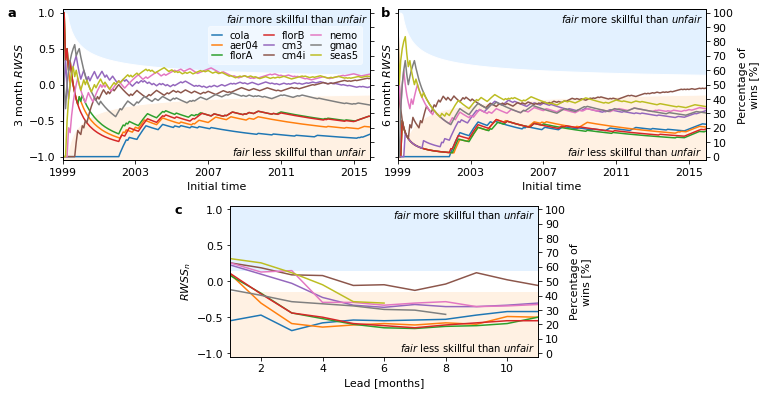

In [87]:
rc_params = {'figure.figsize'      : (9.5, 2.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.5,
             'legend.labelspacing' : 0.01,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()
#     axes_locs = [[0,1,1,0.45],[0,0.5,1,0.45],[0,-0.08,1,0.45]]
    axes_locs = [[0,4.4,0.45,1],[0.49,4.4,0.45,1],[0.49/2,3.1,0.45,1]]
#     axes_locs = [[0.49,4.4,0.45,1],[0.49,3.3,0.45,1],[0.49,2.2,0.45,1],[0.49,1.1,0.45,1],[0.49,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('unfair',anomaly_gp)] #, ('unfair-cv:7yr',anomaly_gp)]
    labels = ['a','b','c','d','e','f']
    # models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    # model_name = ['cola','aer04','florA','florB','cm3','cm4']

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                   model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                   obs_nino34[anomaly_gp].sel(init_date=test_period))
                sign = sign_test['sign_test']
                conf = sign_test['confidence']
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color='w', label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(test_period[0],
                            test_period[-1])
                ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
                ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
#                 if axI ==1:
                ax.set_xlabel('Initial time')
#                 else:
#                     ax.set_xticklabels([])
                    
                ax.set_ylabel(f'{str(lead)} month $RWSS$', labelpad=-2 if axI ==1 else None)  
                    
                if (model_name == 'cola'):
                    if axI ==1: 
                        ax.text(-0.055,0.95,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
                    else:
                        ax.text(-0.18,0.95,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(-0.025, 1.025)
                if axI ==1: 
                    if (model_name == 'cola'):
                        ax2.set_yticks(np.arange(0,1.1,0.1))
                        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
                        ax2.set_ylabel('Percentage of\nwins [%]')
                    else:
                        ax2.set_yticks([])
                else:
                    if (model_name == 'cola'):
                        ax2.set_yticks(np.arange(0,1.1,0.1))
                        ax2.set_yticklabels([])
                    else:
                        ax2.set_yticks([])

                ax.set_ylim(-1.05,1.05)
                if axI ==1: 
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola') & (idx == 0):
                    ax.text(0.99, 0.98, '$fair$ more skillful than $unfair$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.02, '$fair$ less skillful than $unfair$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
                elif (model_name == 'cola') & (idx == 1):
                    ax.text(0.99, 0.98, '$fair$ more skillful\nthan $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.02, '$fair$ less skillful\nthan $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

                if (idx == 0) & (idz == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                    leg = legend = ax.legend(ncol=3, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.92], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]
            sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                obs_nino34[anomaly_gp].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola') & (idx == 0):
                ax.text(0.99, 0.98, '$fair$ more skillful than $unfair$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.02, '$fair$ less skillful than $unfair$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
            elif (model_name == 'cola') & (idx == 1):
                ax.text(0.99, 0.98, '$fair$ more skillful\nthan $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.02, '$fair$ less skillful\nthan $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

            ax.set_ylim(-1.05,1.05)
            ax.set_ylabel('$RWSS_n$')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            ax.set_xlabel('Lead [months]')
                
            col_n += 1
            
            if (model_name == 'cola'):
                ax.text(-0.18,0.95,labels[axI+1],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of\nwins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-cheat.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'Fig3_RWSSfair-unfair.pdf', format='pdf', bbox_inches='tight')

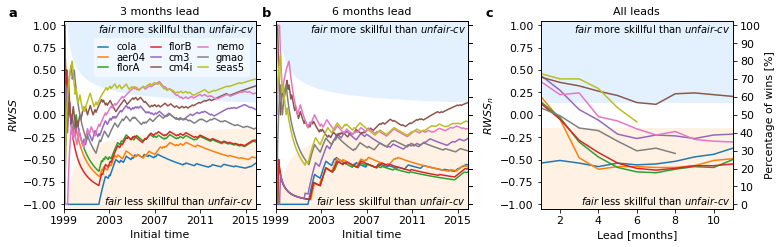

In [111]:
rc_params = {'figure.figsize'      : (9.2, 5.8),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.5,
             'legend.labelspacing' : 0.01,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()
    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45]]#,
#                 [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('unfair-cv:7yr',anomaly_gp)]
    labels = ['a','b','c','d','e','f']
    # models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    # model_name = ['cola','aer04','florA','florB','cm3','cm4']

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                   model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                   obs_nino34[anomaly_gp].sel(init_date=test_period))
                sign = sign_test['sign_test']
                conf = sign_test['confidence']
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color='w', label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(test_period[0],
                            test_period[-1])
                ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
                ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
                ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('$RWSS$')
                if idx == 0:
                    ax.set_title(str(lead) + ' months lead')
                    
                if (model_name == 'cola'):
                    if labels[axI] in ['a','c','d','f']:
                        ax.text(-0.29,1.02,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
                    else:
                        ax.text(-0.07,1.02,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(-0.025, 1.025)
                ax2.set_yticks(np.arange(0,1.1,0.1))
                ax2.set_yticklabels([])
                #ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.05,1.05)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola'):
                    ax.text(0.99, 0.99, '$fair$ more skillful than $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.01, '$fair$ less skillful than $unfair$-$cv$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

                if (idx == 0) & (idz == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                    leg = legend = ax.legend(ncol=3, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.935], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]
            sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble').sel(init_date=test_period), 
                                                model[anom[1]].mean('ensemble').sel(init_date=test_period), 
                                                obs_nino34[anomaly_gp].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola'):
                ax.text(0.99, 0.99, '$fair$ more skillful than $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.01, '$fair$ less skillful than $unfair$-$cv$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

            ax.set_ylim(-1.05,1.05)
            ax.set_ylabel('$RWSS_n$')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            col_n += 1
            
            if (model_name == 'cola'):
                ax.text(-0.29,1.02,labels[axI+1],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-cheat.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigS_RWSSfair-unfaircv.pdf', format='pdf', bbox_inches='tight')

# How do the model **fair** anomalies compare when assessed relative to observed **fair-sliding** anomalies?

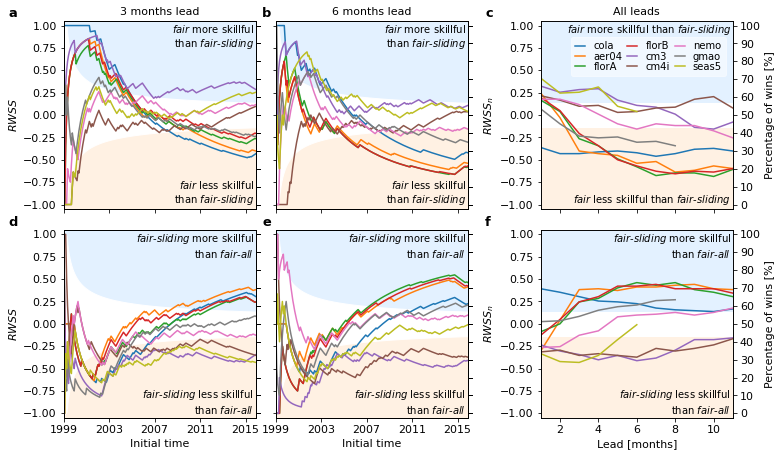

In [68]:
rc_params = {'figure.figsize'      : (9.2, 5.8),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.5,
             'legend.labelspacing' : 0.01,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()
    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('fair-sliding',anomaly_gp), ('fair-all', 'fair-sliding')]
    labels = ['a','b','c','d','e','f']

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                    model[anom[1]].mean('ensemble'), 
                                                    obs_nino34[anomaly_gp].sel(init_date=test_period))
                sign = sign_test['sign_test']
                conf = sign_test['confidence']
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color='w', label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(np.datetime64(test_period[0]),
                            np.datetime64(test_period[-1]))
                ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
                ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])
                if axI < len(anoms) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('$RWSS$')
                if idx == 0:
                    ax.set_title(str(lead) + ' months lead')
                    
                if (model_name == 'cola'):
                    if labels[axI] in ['a','c','d','f']:
                        ax.text(-0.29,1.02,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
                    else:
                        ax.text(-0.07,1.02,labels[axI],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(-0.025, 1.025)
                ax2.set_yticks(np.arange(0,1.1,0.1))
                ax2.set_yticklabels([])
                #ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.05,1.05)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola') & (idx == 0):
                    ax.text(0.99, 0.99, '$fair$ more skillful\nthan $fair$-$sliding$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.01, '$fair$ less skillful\nthan $fair$-$sliding$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
                elif (model_name == 'cola') & (idx == 1):
                    ax.text(0.99, 0.99, '$fair$-$sliding$ more skillful\nthan $fair$-$all$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                    ax.text(0.99, 0.01, '$fair$-$sliding$ less skillful\nthan $fair$-$all$', 
                            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom') 
                    
            ax = axes[axI+1]
            sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_nino34[anomaly_gp].sel(init_date=test_period))
            sign = sign_test['sign_test']
            conf = sign_test['confidence']
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date=test_period[-1]), 
                                conf_plot.sel(init_date=test_period[-1]), color='w', label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date=test_period[-1]), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola') & (idx == 0):
                ax.text(0.99, 0.99, '$fair$ more skillful than $fair$-$sliding$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.01, '$fair$ less skillful than $fair$-$sliding$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

            elif (model_name == 'cola') & (idx == 1):
                ax.text(0.99, 0.99, '$fair$-$sliding$ more skillful\nthan $fair$-$all$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
                ax.text(0.99, 0.01, '$fair$-$sliding$ less skillful\nthan $fair$-$all$', 
                        transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

            ax.set_ylim(-1.05,1.05)
            ax.set_ylabel('$RWSS_n$')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(anoms) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            if (idx == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                leg = legend = ax.legend(ncol=3, fontsize=fontsize-1, loc='upper right', 
                                         bbox_to_anchor=[0.00,0.00,0.99,0.94], 
                                         framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')
                
            col_n += 1
            
            if (model_name == 'cola'):
                ax.text(-0.29,1.02,labels[axI+1],fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(-0.025, 1.025)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-fairsliding.eps', format='eps', bbox_inches='tight') 
    plt.savefig(saveloc + 'FigS_RWSSfair-fairsliding.pdf', format='pdf', bbox_inches='tight')

# Let's look at the model climatologies over the hindcast and verification periods

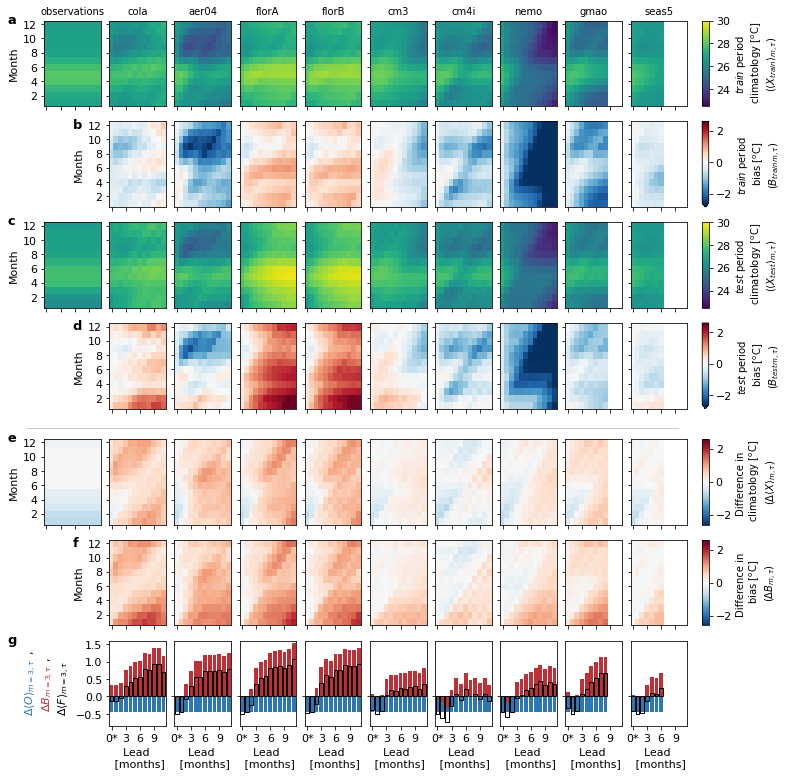

In [60]:
rc_params = {'figure.figsize'      : (9.05, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}

full_cmap = mpl.cm.viridis
diff_cmap = mpl.cm.RdBu_r

bar_month = 3

full_vlims = (22.5, 30)
diff_vlims = (-2.6, 2.6)
    
col_bar_O = diff_cmap(0+35)
col_bar_B = diff_cmap(256-35)

with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    grey = [0.8,0.8,0.8]
    
    models = {**{'observations': obs_nino34}, **fcst_nino34}

    width = 0.087
    height = 0.17
    axes_locs = [[x, 0.8, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, 0.6, width, height] for x in np.arange(1/len(models), 1, 1/len(models))] + \
                [[x, 0.4, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, 0.2, width, height] for x in np.arange(1/len(models), 1, 1/len(models))] + \
                [[x, -0.03, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, -0.23, width, height] for x in np.arange(1/len(models), 1, 1/len(models))] + \
                [[x, -0.43, width, height] for x in np.arange(1/len(models), 1, 1/len(models))]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    count = 0
    for model_name, model in models.items():
        if model_name == 'observations':
            train_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=train_period)), 
                                                  init_date_coord='month')
            train_clim = train_clim.sel(lead_time=0) * (1 + 0*train_clim)
            obs_train_clim = train_clim
            test_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=test_period)), 
                                                 init_date_coord='month')
            test_clim = test_clim.sel(lead_time=0) * (1 + 0*test_clim)
            obs_test_clim = test_clim
        else:
            train_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=train_period)), 
                                                  init_date_coord='month')
            test_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=test_period)), 
                                                 init_date_coord='month')

        ax0 = axes[count]
        ax1 = axes[count + len(models) - 1]
        ax2 = axes[count + 2*len(models) - 1]
        ax3 = axes[count + 3*len(models) - 2]
        ax4 = axes[count + 4*len(models) - 2]
        ax5 = axes[count + 5*len(models) - 3]
        ax6 = axes[count + 6*len(models) - 4]

        p1 = train_clim.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=full_vlims[0], vmax=full_vlims[1], cmap=full_cmap) 
#         print(model_name, train_clim.min().item())
#         print(model_name, train_clim.max().item())
        if model_name != 'observations':
            p2 = (train_clim - obs_train_clim).plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=diff_vlims[0], vmax=diff_vlims[1], cmap=diff_cmap) 
#             print(model_name, (train_clim - obs_train_clim).min().item(), (train_clim - obs_train_clim).max().item())
        p3 = test_clim.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=full_vlims[0], vmax=full_vlims[1], cmap=full_cmap) 
#         print(model_name, test_clim.min().item())
#         print(model_name, test_clim.max().item())
        if model_name != 'observations':
            p4 = (test_clim - obs_test_clim).plot(x='lead_time',ax=ax3, add_colorbar=False, vmin=diff_vlims[0], vmax=diff_vlims[1], cmap=diff_cmap) 
#             print(model_name, (test_clim - obs_test_clim).min().item(), (test_clim - obs_test_clim).max().item())
        p5 = (test_clim - train_clim).plot(x='lead_time',ax=ax4, add_colorbar=False, vmin=diff_vlims[0], vmax=diff_vlims[1], cmap=diff_cmap) 
        if model_name != 'observations':
            p6 = ((test_clim - obs_test_clim) - (train_clim - obs_train_clim)).plot(x='lead_time',ax=ax5, add_colorbar=False, vmin=diff_vlims[0], vmax=diff_vlims[1], cmap=diff_cmap) 
            # keep = (abs((test_clim - obs_test_clim) - (train_clim - obs_train_clim)) > 0.05) & (abs(obs_test_clim - obs_train_clim) > 0.05)
            # p7 = (abs((test_clim - obs_test_clim) - (train_clim - obs_train_clim)) / abs(obs_test_clim - obs_train_clim)).where(keep).plot.imshow(x='lead_time',ax=ax6, add_colorbar=False, vmin=0.1, vmax=10, norm=norm, cmap=diff_cmap) 
            fcst_leads = test_clim.lead_time.values
            ax6.bar(obs_test_clim.lead_time.sel(lead_time=fcst_leads),
                    (obs_test_clim - obs_train_clim).sel(month=bar_month).sel(lead_time=fcst_leads), color=col_bar_O)
            ax6.bar(((test_clim - obs_test_clim) - (train_clim - obs_train_clim)).lead_time,
                    ((test_clim - obs_test_clim) - (train_clim - obs_train_clim)).sel(month=bar_month), color=col_bar_B)
            ax6.bar((test_clim - train_clim).lead_time,
                    (test_clim - train_clim).sel(month=bar_month), fill=False, edgecolor='k')
        if count == (len(models)-1):
            ps = [p1, p2, p3, p4, p5, p6]
            cax_y = [0.8, 0.6,0.4,0.2,-0.03, -0.23]
            label = ['$train$ period \n climatology [$^\mathrm{o}$C]'+
                     '\n($\langle X_{train} \\rangle_{m,\\tau}$)',
                    '$train$ period \n bias [$^\mathrm{o}$C]'+
                     '\n(${B_{train}}_{m,\\tau}$)',
                    '$test$ period \n climatology [$^\mathrm{o}$C]'+
                     '\n($\langle X_{test} \\rangle_{m,\\tau}$)',
                    '$test$ period \n bias [$^\mathrm{o}$C]'+
                     '\n(${B_{test}}_{m,\\tau}$)',
                    'Difference in \n climatology [$^\mathrm{o}$C]'+
                     '\n($\Delta \langle X \\rangle_{m,\\tau}$)',
                    'Difference in \n bias [$^\mathrm{o}$C]'+
                     '\n($\Delta  B_{m,\\tau}$)']
            for idc, p in enumerate(ps):
                cbaxes = fig.add_axes([1.01, cax_y[idc], 0.01, height]) 
                cb = plt.colorbar(p, cax = cbaxes, 
                                  extend='min' if (idc == 1) | (idc == 3) | (idc == 6) else 'neither', 
                                  ticks=[0.1,0.5,1,5,10] if (idc == 6) else None)
                cb.set_label(label[idc], rotation=90, fontsize=fontsize-1)

        if (count == 0):
            ax0.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax4.set_yticks(np.arange(0,13,2))
            ax0.set_ylabel('Month')
            ax0.text(-0.65,0.97,'a',fontsize=label_fontsize,weight="bold",transform=ax0.transAxes)
            ax2.set_ylabel('Month')
            ax2.text(-0.65,0.97,'c',fontsize=label_fontsize,weight="bold",transform=ax2.transAxes)
            ax4.set_ylabel('Month')
            ax4.text(-0.65,0.97,'e',fontsize=label_fontsize,weight="bold",transform=ax4.transAxes)
        else:
            ax0.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax4.set_yticks(np.arange(0,13,2))
            ax0.set_yticklabels([])
            ax2.set_yticklabels([])
            ax4.set_yticklabels([])
            ax0.set_ylabel('')
            ax2.set_ylabel('')
            ax4.set_ylabel('')

        if (count == 1):
            ax1.set_yticks(np.arange(0,13,2))
            ax3.set_yticks(np.arange(0,13,2))
            ax5.set_yticks(np.arange(0,13,2))
            ax6.set_yticks(np.arange(-0.5,2.5,0.5))
            ax1.set_ylabel('Month')
            ax1.text(-0.65,0.92,'b',fontsize=label_fontsize,weight="bold",transform=ax1.transAxes)
            ax3.set_ylabel('Month')
            ax3.text(-0.65,0.92,'d',fontsize=label_fontsize,weight="bold",transform=ax3.transAxes)
            ax5.set_ylabel('Month')
            ax5.text(-0.65,0.92,'f',fontsize=label_fontsize,weight="bold",transform=ax5.transAxes)
            # ax6.set_ylabel('Difference [$^\mathrm{o}$C]')
#             ax6.text(-19, -0.05, 'March', rotation=90, color='k')
#             ax6.text(-15, -0.73, '$\Delta \langle O \\rangle_{m,\\tau}$', rotation=90, color=col_bar_O)
#             ax6.text(-14.5, 0.50, ',', rotation=90, color='k')
#             ax6.text(-15, 0.70, '$\Delta  B_{m,\\tau}$', rotation=90, color=col_bar_B)
#             ax6.text(-14.5, 1.62, ',', rotation=90, color='k')
#             ax6.text(-11, -0.08, '$\Delta \langle F \\rangle_{m,\\tau}$', rotation=90, color='k')
            # ax6.text(-15, -0.7, 'March', rotation=90, color='k')
            ax6.text(-18.5, -0.4, '$\Delta \langle O \\rangle_{m=3,\\tau}$', rotation=90, color=col_bar_O)
            ax6.text(-18.5, 1.3, ',', rotation=90, color='k')
            ax6.text(-15, -0.30, '$\Delta  B_{m=3,\\tau}$', rotation=90, color=col_bar_B)
            ax6.text(-15, 1.1, ',', rotation=90, color='k')
            ax6.text(-11.5, -0.4, '$\Delta \langle F \\rangle_{m=3,\\tau}$', rotation=90, color='k')
            ax6.text(-1.8,0.97,'g',fontsize=label_fontsize,weight="bold",transform=ax6.transAxes)
        else:
            ax1.set_yticks(np.arange(0,13,2))
            ax3.set_yticks(np.arange(0,13,2))
            ax5.set_yticks(np.arange(0,13,2))
            ax6.set_yticks(np.arange(0,13,2))
            ax1.set_yticklabels([])
            ax3.set_yticklabels([])
            ax5.set_yticklabels([])
            ax6.set_yticklabels([])
            ax1.set_ylabel('')
            ax3.set_ylabel('')
            ax5.set_ylabel('')
            ax6.set_ylabel('')

        ax0.set_xticks(np.arange(0,13,3))
        ax0.set_xticklabels([])
        ax0.set_xlabel('')
        ax1.set_xticks(np.arange(0,13,3))
        ax1.set_xticklabels([])
        ax1.set_xlabel('')
        ax2.set_xticks(np.arange(0,13,3))
        ax2.set_xticklabels([])
        ax2.set_xlabel('')
        ax3.set_xticks(np.arange(0,13,3))
        ax3.set_xticklabels([])
        ax3.set_xlabel('')
        ax4.set_xticks(np.arange(0,13,3))
        ax4.set_xticklabels([])
        ax4.set_xlabel('')
        ax5.set_xticks(np.arange(0,13,3))
        ax5.set_xticklabels([])
        ax5.set_xlabel('')
        ax6.set_xticks(np.arange(0,13,3))
        ax6.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
        ax6.set_xlabel('Lead \n [months]')
        ax0.set_title(model_name, fontsize=fontsize-1)

        ax0.set_xlim(-0.5,11.5)
        ax1.set_xlim(-0.5,11.5)
        ax2.set_xlim(-0.5,11.5)
        ax3.set_xlim(-0.5,11.5)
        ax4.set_xlim(-0.5,11.5)
        ax5.set_xlim(-0.5,11.5)
        ax6.set_xlim(-0.5,11.5)
        ax0.set_ylim(0.5,12.5)
        ax1.set_ylim(0.5,12.5) 
        ax2.set_ylim(0.5,12.5)
        ax3.set_ylim(0.5,12.5)
        ax4.set_ylim(0.5,12.5)
        ax5.set_ylim(0.5,12.5)
        ax6.set_ylim(-0.85,1.6)
        
#         ax6.spines['right'].set_visible(False)
#         ax6.spines['top'].set_visible(False)
#         ax6.yaxis.set_ticks_position('left')
#         ax6.xaxis.set_ticks_position('bottom')

        if count == 1:
            ax4.plot([-18,12*len(models)],[14,14], color=grey, linewidth=linewidth-0.5, clip_on=False)

        count += 1

#     plt.savefig(saveloc + 'nino34_climatologies_contour.eps', format='eps', bbox_inches='tight')
#     plt.savefig(saveloc + 'Fig4_contours.pdf', format='pdf', bbox_inches='tight')

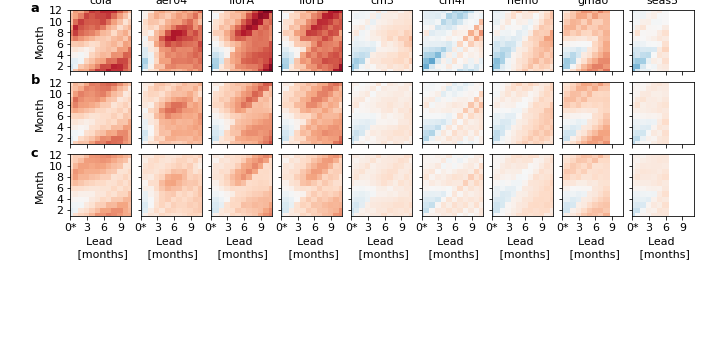

In [221]:
rc_params = {'figure.figsize'      : (9.05, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.03,
             'legend.handlelength' : 1,
             'lines.linewidth'     : linewidth}
vlims = (-1.4,1.4)

with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    grey = [0.8,0.8,0.8]
    
    models = fcst_nino34

    width = 0.087
    height = 0.17
    
    axes_locs = [[x, 0.8, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))] + \
                [[x, 0.6, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))] + \
                [[x, 0.4, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    train_period = slice('1982','1998')
    test_period = slice('1999','2015')

    count = 0
    for model_name, model in models.items():
        fair = init_date_to_target_date(monthly_climatology(model['fair'].sel(init_date=test_period)), 
                                        init_date_coord='month')
        fair_slide = init_date_to_target_date(monthly_climatology(model['fair-sliding'].sel(init_date=test_period)), 
                                              init_date_coord='month')
        fair_all = init_date_to_target_date(monthly_climatology(model['fair-all'].sel(init_date=test_period)), 
                                            init_date_coord='month')

        ax0 = axes[count]
        ax1 = axes[count + len(models) ]
        ax2 = axes[count + 2*len(models) ]

        p1 = fair.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=vlims[0], vmax=vlims[1], cmap='RdBu_r') 
        p2 = fair_all.plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=vlims[0], vmax=vlims[1], cmap='RdBu_r') 
        p3 = fair_slide.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=vlims[0], vmax=vlims[1], cmap='RdBu_r') 

        if count == (len(models)-1):
            ps = [p1, p2, p3]
            cax_y = [0.8, 0.6, 0.4,]
            label = ['Mean $fair$ \nanomalies [$^\mathrm{o}$C]',
                    'Mean $fair$-$all$ \nanomalies [$^\mathrm{o}$C]',
                    'Mean $fair$-$sliding$ \nanomalies [$^\mathrm{o}$C]']
            for idc, p in enumerate(ps):
                cbaxes = fig.add_axes([1.01, cax_y[idc], 0.01, height]) 
                cb = plt.colorbar(p, cax = cbaxes)
                cb.set_label(label[idc], rotation=90, fontsize=11)

        if (count == 0):
            ax0.set_yticks(np.arange(0,13,2))
            ax0.text(-0.65,0.97,'a',fontsize=label_fontsize,weight="bold",transform=ax0.transAxes)
            ax1.set_yticks(np.arange(0,13,2))
            ax1.text(-0.65,0.97,'b',fontsize=label_fontsize,weight="bold",transform=ax1.transAxes)
            ax2.set_yticks(np.arange(0,13,2))
            ax2.text(-0.65,0.97,'c',fontsize=label_fontsize,weight="bold",transform=ax2.transAxes)
            ax0.set_ylabel('Month')
            ax1.set_ylabel('Month')
            ax2.set_ylabel('Month')
        else:
            ax0.set_yticks(np.arange(0,13,2))
            ax1.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax0.set_yticklabels([])
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
            ax0.set_ylabel('')
            ax1.set_ylabel('')
            ax2.set_ylabel('')    

        ax0.set_xticks(np.arange(0,13,3))
        ax0.set_xticklabels([])
        ax0.set_xlabel('')
        ax1.set_xticks(np.arange(0,13,3))
        ax1.set_xticklabels([])
        ax1.set_xlabel('')
        ax2.set_xticks(np.arange(0,13,3))
        ax2.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
        ax2.set_xlabel('Lead \n [months]')
        ax0.set_title(model_name, fontsize=11)

        ax0.set_xlim(0,11)
        ax1.set_xlim(0,11) 
        ax2.set_xlim(0,11)
        ax0.set_ylim(1,12)
        ax1.set_ylim(1,12) 
        ax2.set_ylim(1,12)
        
        count += 1

    # plt.savefig(saveloc + 'nino34_mean_anomalies.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigS_contours.pdf', format='pdf', bbox_inches='tight')

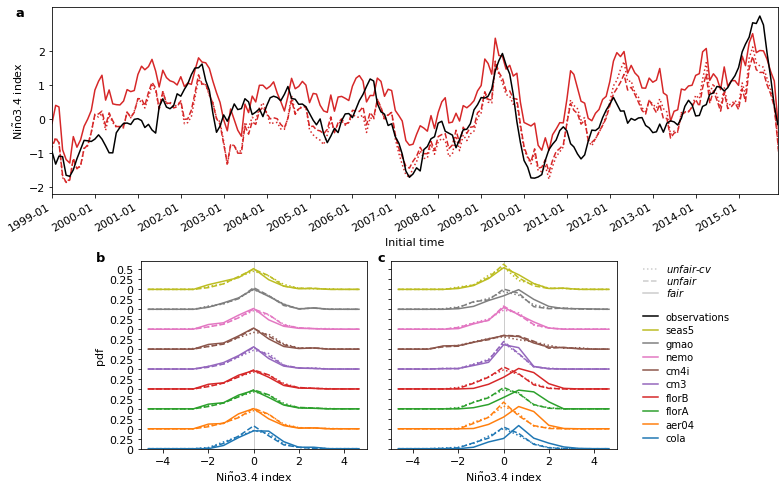

In [213]:
rc_params = {'figure.figsize'      : (11.2, 5.2),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 0.7,
             'legend.labelspacing' : 0.35,
             'legend.handlelength' : 1.5,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    
    grey = [0.8,0.8,0.8]

    fig = plt.figure()
    axes_locs = [[0.1,0.68,0.9,0.5], 
                 [0.21,0,0.28,0.5],[0.52,0,0.28,0.5]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    # Timeseries plot -----
    ax = axes[0]
    lead=6
    model = florB_nino34.mean('ensemble')
    model['unfair'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='--', label='$unfair$')
    model['unfair-cv:7yr'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle=':', label='$unfair-cv$')
    obs_nino34['unfair'].sel(lead_time=lead).plot(ax=ax, color='k', label='observations ($o_{\mathrm{test}}^{\mathrm{obs}}$)', zorder=10)
    model['fair'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='-', label='$fair$')

#     ax.grid(True, which='both')
#     ax.set_axisbelow(True)
    
    ax.set_xlim(np.datetime64(test_period[0]),
                np.datetime64(test_period[-1]))
    ax.set_xticks(pd.date_range(start=test_period[0],
                                end=test_period[-1],
                                freq='12MS'))
    ax.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range(start=test_period[0],
                                                                         end=test_period[-1],
                                                                         freq='12MS')],
                      rotation=30)
    ax.set_ylim(-2.2,3.3);
    ax.set_xlabel('Initial time')
    ax.set_ylabel(r'Ni$\tilde{\mathrm{n}}$o3.4 index')
    ax.set_title('');
    ax.set_yticks(np.arange(-2,3,1))

    ax.text(-0.05,0.95,'a',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
        
    # pdf plots -----
    leads = [0, 6]
    models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    model_name = ['cola','aer04','florA','florB','cm3','cm4']

    for idy, lead in enumerate(leads):
        ax = axes[idy+1]

        col_n = 0
        for model_name, model in fcst_nino34.items():

            pdf_mod_c1ncv = doppyo.utils.pdf((model['unfair'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n
            pdf_mod_c17yr = doppyo.utils.pdf((model['unfair-cv:7yr'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n
            pdf_mod_c2 = doppyo.utils.pdf((model['fair'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n


            pdf_mod_c1ncv.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle='--', label='_nolabel_')
            pdf_mod_c17yr.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle=':', label='_nolabel_')
            pdf_mod_c2.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle='-', label=model_name)

            col_n += 1
            
        if idy == 0: # Add observations so that in legend
            ax.plot([1000,1001], [1000,1001], color='k', linestyle='-', label='observations')
                
        ax.set_ylim(0,0.5*(len(models))+0.1)
        ax.set_xlabel(r'Ni$\tilde{\mathrm{n}}$o3.4 index')
        if idy == 0:
            ax.text(-0.2,1.0,'b',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
        else:
            ax.text(-0.06,1.0,'c',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
        ax.set_title('')
        if idy == 0:
            ax.set_yticks(np.arange(0,len(fcst_nino34)/2+0.3,0.25));
            ax.set_yticklabels([0,0.25]*len(fcst_nino34)+[0.5,0.75]);
        else:
            ax.set_yticks(np.arange(0,len(fcst_nino34)/2+0.3,0.25));
            ax.set_yticklabels([]);
            ax.set_ylabel('')
        ax.set_xticks(np.arange(-6,6,2))
        ax.set_xlim(-5,5)
        ax.plot([0, 0],[0, len(fcst_nino34)/2+0.2], color=grey, zorder=0, linewidth=linewidth-0.5)
        ax.set_ylim(0,len(fcst_nino34)/2+0.2)

        if idy == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[::-1], labels[::-1],
                               ncol=1, loc='lower right', bbox_to_anchor=[1.048,-0.02,1.6,1], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

    span = np.array([6.16,6.82])
    ax.plot(span,4.5*np.ones_like(span.astype(int)), linestyle=':', color=grey, clip_on=False)
    ax.text(7.18, 4.43, '$unfair$-$cv$', fontsize=fontsize-1)
    ax.plot(span,4.2*np.ones_like(span.astype(int)), linestyle='--', color=grey, clip_on=False)
    ax.text(7.18, 4.13, '$unfair$', fontsize=fontsize-1)
    ax.plot(span,3.9*np.ones_like(span.astype(int)), linestyle='-', color=grey, clip_on=False)
    ax.text(7.18, 3.83, '$fair$', fontsize=fontsize-1);

    # plt.savefig(saveloc + 'nino34_timeseries_pdflead0and6_CV.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigB4_crossvalidation.pdf', format='pdf', bbox_inches='tight')

# Plot schematic showing how onset and decay are defined

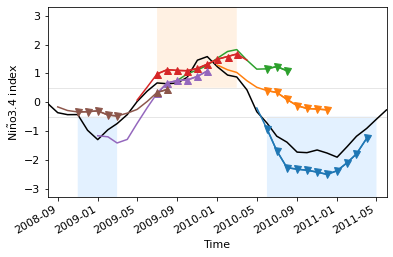

In [214]:
rc_params = {'figure.figsize'      : (5.6, 3.7),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    
    figure = plt.figure()
    grey = [0.9,0.9,0.9]

    fcst_dates = pd.date_range(start='2008-09', end='2010-07', freq='4MS')[::-1]
    fcst_to_plot = fcst_nino34['cm4i']
    
    (0.5+0*obs_nino34[anomaly_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=linewidth-0.5, zorder=0)
    (-0.5+0*obs_nino34[anomaly_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=linewidth-0.5, zorder=0)
    obs_nino34[anomaly_gp].sel(lead_time=0).plot(color='k', linestyle='-', label='Observations', zorder=0)

    plt.fill_between(obs_nino34[anomaly_gp].sel(lead_time=0).init_date.values,
                     100*obs_nino34[anomaly_gp].where(obs_where_elnino[anomaly_gp]).sel(lead_time=0),
                     0.5, #-100*obs_nino34[anomaly_gp].where(obs_where_elnino[anomaly_gp]).sel(lead_time=0),
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    plt.fill_between(obs_nino34[anomaly_gp].sel(lead_time=0).init_date.values,
                     100*obs_nino34[anomaly_gp].where(obs_where_lanina[anomaly_gp]).sel(lead_time=0),
                     -0.5, #-100*obs_nino34[anomaly_gp].where(obs_where_lanina[anomaly_gp]).sel(lead_time=0),
                     facecolor=upper_color, linewidth=0.0, zorder=0)

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='NMME individual model ensemble average')

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].where(obs_where_elnino_onset[anomaly_gp]).sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='_nolegend_', marker='^', markersize=7)

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].where(obs_where_lanina_onset[anomaly_gp]).sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='_nolegend_', marker='v', markersize=7)

    # plt.plot(['1997-01','1999-01'],[0.5,0.5], zorder=0)
    # plt.plot(['2007','2012'],[-0.5,-0.5], zorder=0)
    plt.xlim('2008-08','2011-06')
    plt.ylim(-3.3,3.3);
    plt.xlabel('Time');
    plt.ylabel(r'Ni$\tilde{\mathrm{n}}$o3.4 index');
    plt.title('')

    plt.tight_layout();
    # plt.savefig(saveloc + 'nino34_onset_schematic.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'FigM_onset.pdf', format='pdf', bbox_inches='tight')

# What about onset of El Nino and La Nina?

CPU times: user 3.66 s, sys: 321 ms, total: 3.98 s
Wall time: 4.28 s


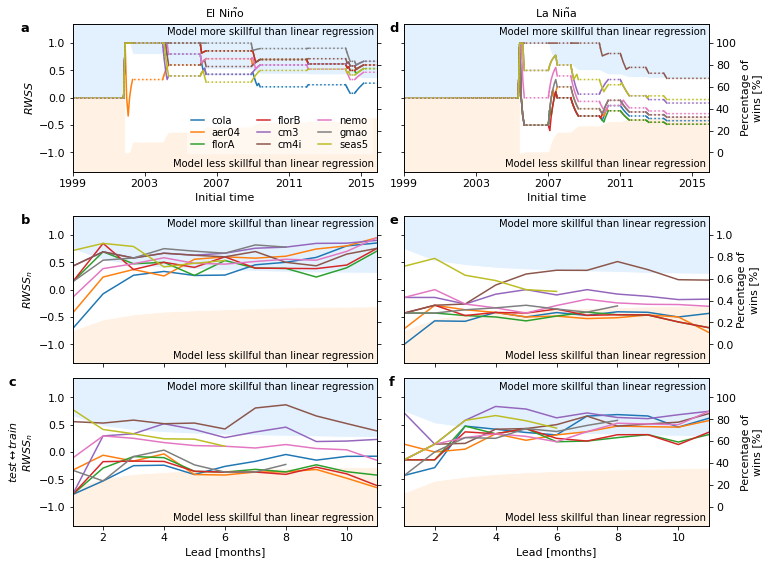

In [57]:
%%time
n_bootstraps = 1000
n_random_ensembles = len(fcst_nino34[list(fcst_nino34.keys())[0]].ensemble)
n_random_init_dates = len(fcst_nino34[list(fcst_nino34.keys())[0]].sel(init_date=test_period).init_date)
quantiles = [0.05, 0.95]

rc_params = {'figure.figsize'      : (9.4, 2.05),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 1.6,
             'legend.labelspacing' : 0.2,
             'legend.handlelength' : 1.3,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()

#     axes_locs = [[0,0.75,0.29,0.225], [0.4,0.75,0.29,0.225], [0.72,0.75,0.29,0.225],
#                                       [0.4,0.5,0.29,0.225],  [0.72,0.5,0.29,0.225]]
    axes_locs = [[0,4.6,0.45,1],[0,3.3,0.45,1],[0,2.2,0.45,1]] #,[0,1.1,0.45,1],[0,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    lead = 6
    masks = [obs_where_elnino_onset, obs_where_elnino_onset, obs_where_elnino_onset_switched,
                                     obs_where_elnino_onset, obs_where_elnino_onset_switched]
    models = [fcst_nino34, fcst_nino34, fcst_nino34_switched,
                           fcst_nino34, fcst_nino34_switched]
    obsvs = [obs_nino34, obs_nino34, obs_nino34_switched,
                         obs_nino34, obs_nino34_switched]
    bases = [regr_nino34['linear regression'], regr_nino34['linear regression'], regr_nino34_switched['linear regression'],
                                               regr_nino34['linear regression'], regr_nino34_switched['linear regression']]
    
    # Random walk at lead_time=lead -----
    # ================================================================================
    idx = 0
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            (conf_plot).sel(lead_time=lead), color='w', label='_nolegend_')

        ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], alpha=0.1)
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anomaly_gp]==0) | (masks[idx][anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], linestyle=':')
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anomaly_gp]==1) | (masks[idx][anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    ax.set_xlim(np.datetime64(test_period[0]),
                np.datetime64(test_period[-1]))
    ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
    ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])

    ax.set_xlabel('Initial time')
    ax.set_ylabel('$RWSS$')
    ax.set_title(r'El Ni$\tilde{\mathrm{n}}$o', fontsize=fontsize)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])

    ax.set_ylim(-1.35,1.35)
#     if idz > 0:
#         ax.set_yticklabels([])

    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    
    legend = ax.legend(ncol=3, fontsize=fontsize-1, loc='lower right', bbox_to_anchor=[0,0.09,1,1], framealpha=0.5)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    
    ax.text(-0.17,0.95,'a',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score -----
    # ================================================================================
    idx = 1
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=test_period[-1]), 
                            (conf_plot).sel(init_date=test_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)

    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    ax.set_ylabel('$RWSS_n$')
    ax.set_xlim(1,11)
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels([])
#     ax.set_title('All leads')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])
    # ax2.set_ylabel('Percentage of wins [%]')
    
    ax.text(-0.17,0.95,'b',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score (switched) -----
    # ================================================================================
    idx = 2
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=train_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=train_period[-1]), 
                            (conf_plot).sel(init_date=train_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=train_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)

    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    ax.set_ylabel('$test \leftrightarrow train$\n$RWSS_n$')
    ax.set_xlim(1,11)
    ax.set_xlabel('Lead [months]')
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels(np.arange(2,12,2).tolist())
#     ax.set_yticklabels([])
#     ax.set_title('All leads, $test \leftrightarrow train$')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])
#     ax2.set_ylabel('Percentage of wins [%]')

    ax.text(-0.21,0.95,'c',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # MSSS -----
    # ================================================================================
#     idx = 3
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anomaly_gp].where(masks[idx][anomaly_gp]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34}.items():
#         fcst = model[anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp])
#         obs = obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp])
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_ylabel('$MSSS$')
# #     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels([])
#     ax.set_xlim(1,11)

#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylim(-1.35,1.35)
#     ax2.set_yticklabels([])
    
#     ax.text(-0.17,0.95,'d',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # MSSS (switched) -----
    # ================================================================================
#     idx = 4
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anomaly_gp].where(masks[idx][anomaly_gp]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34_switched}.items():
#         fcst = model[anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp])
#         obs = obsvs[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp])
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_ylabel('$test \leftrightarrow train$\n$MSSS$')
#     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels(np.arange(2,12,2).tolist())
# #     ax.set_yticklabels([])
#     ax.set_xlim(1,11)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylim(-1.35,1.35)
#     ax2.set_yticklabels([])
    
#     ax.text(-0.21,0.95,'e',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # La Nina ----- 
    # ================================================================================
    # ================================================================================
    axes_locs = [[0.49,4.6,0.45,1],[0.49,3.3,0.45,1],[0.49,2.2,0.45,1]]#,[0.49,1.1,0.45,1],[0.49,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    lead = 6
    masks = [obs_where_lanina_onset, obs_where_lanina_onset, obs_where_lanina_onset_switched,
                                     obs_where_lanina_onset, obs_where_lanina_onset_switched]
    models = [fcst_nino34, fcst_nino34, fcst_nino34_switched,
                           fcst_nino34, fcst_nino34_switched]
    obsvs = [obs_nino34, obs_nino34, obs_nino34_switched,
                         obs_nino34, obs_nino34_switched]
    bases = [regr_nino34['linear regression'], regr_nino34['linear regression'], regr_nino34_switched['linear regression'],
                                               regr_nino34['linear regression'], regr_nino34_switched['linear regression']]
    
    # Random walk at lead_time=lead -----
    # ================================================================================
    idx = 0
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            (conf_plot).sel(lead_time=lead), color='w', label='_nolegend_')

        ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], alpha=0.1)
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anomaly_gp]==0) | (masks[idx][anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], linestyle=':')
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anomaly_gp]==1) | (masks[idx][anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    ax.set_xlim(np.datetime64(test_period[0]),
                np.datetime64(test_period[-1]))
    ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
    ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])

    ax.set_xlabel('Initial time')
#     ax.set_ylabel('Random walk skill score')
    ax.set_title(r'La Ni$\tilde{\mathrm{n}}$a')
    ax.set_yticklabels([])

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of\nwins [%]')

    ax.set_ylim(-1.35,1.35)

    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    
    ax.text(-0.05,0.95,'d',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score -----
    # ================================================================================
    idx = 1
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=test_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=test_period[-1]), 
                            (conf_plot).sel(init_date=test_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     ax.set_ylabel('Final random walk skill score')
    ax.set_xlim(1,11)
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
#     ax.set_title('All leads')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_ylabel('Percentage of\nwins [%]')
    
    ax.text(-0.05,0.95,'e',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score (switched) -----
    # ================================================================================
    idx = 2
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp]), 
                                           model[anomaly_gp].mean('ensemble').sel(init_date=train_period).where(masks[idx][anomaly_gp]), 
                                           obsvs[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anomaly_gp])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=train_period[-1]), 
                            (conf_plot).sel(init_date=train_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=train_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    # ax.set_ylabel('Final random walk skill score')
    ax.set_xlim(1,11)
    ax.set_xlabel('Lead [months]')
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels(np.arange(2,12,2).tolist())
    ax.set_yticklabels([])
#     ax.set_title('All leads, $test \leftrightarrow train$')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of\nwins [%]')
    
    ax.text(-0.05,0.95,'f',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # MSSS -----
    # ================================================================================
#     idx = 3
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anomaly_gp].where(masks[idx][anomaly_gp]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34}.items():
#         fcst = model[anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp], drop=True)
#         obs = obsvs[idx][anomaly_gp].sel(init_date=test_period).where(masks[idx][anomaly_gp], drop=True)
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_yticklabels([])
# #     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels([])
#     ax.set_xlim(1,11)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylabel('$MSSS$')
#     ax2.set_ylim(-1.35,1.35)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax.text(-0.05,0.95,'i',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # MSSS (switched) -----
    # ================================================================================
#     idx = 4
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anomaly_gp].where(masks[idx][anomaly_gp]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34_switched}.items():
#         fcst = model[anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp], drop=True)
#         obs = obsvs[idx][anomaly_gp].sel(init_date=train_period).where(masks[idx][anomaly_gp], drop=True)
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
# #     ax.set_ylabel('Mean squared skill score')
#     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels(np.arange(2,12,2).tolist())
#     ax.set_yticklabels([])
#     ax.set_xlim(1,11)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylabel('$test \leftrightarrow train$\n$MSSS$')
#     ax2.set_ylim(-1.35,1.35)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax.text(-0.05,0.95,'j',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    plt.savefig(saveloc + 'Fig5_RWSSonset.pdf', format='pdf', bbox_inches='tight')

CPU times: user 3.4 s, sys: 300 ms, total: 3.7 s
Wall time: 3.78 s


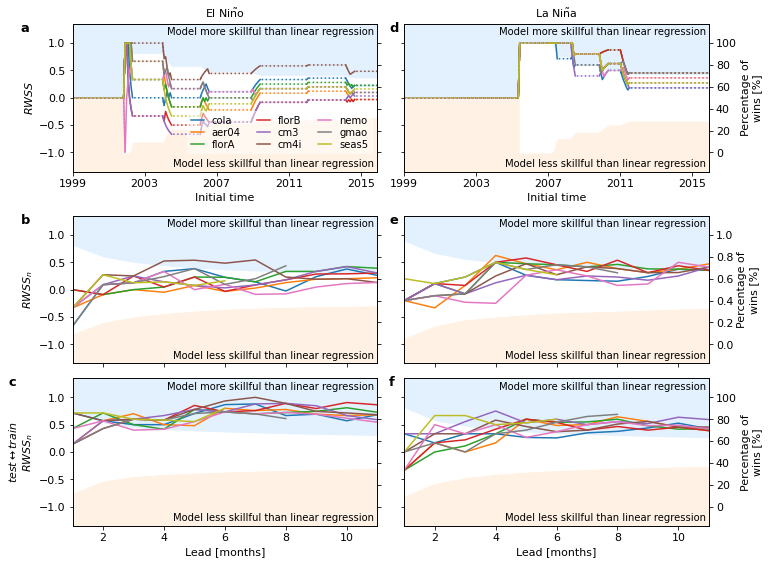

In [58]:
%%time
anom = 'unfair'
n_bootstraps = 10
n_random_ensembles = len(fcst_nino34[list(fcst_nino34.keys())[0]].ensemble)
n_random_init_dates = len(fcst_nino34[list(fcst_nino34.keys())[0]].sel(init_date=test_period).init_date)
quantiles = [0.05, 0.95]

rc_params = {'figure.figsize'      : (9.4, 2.05),
             'axes.titlesize'      : 'medium',
             'font.size'           : fontsize,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : fontsize-1,
             'legend.columnspacing': 1.6,
             'legend.labelspacing' : 0.2,
             'legend.handlelength' : 1.3,
             'lines.linewidth'     : linewidth}
    
with mpl.rc_context(rc=rc_params):
    fig = plt.figure()

#     axes_locs = [[0,0.75,0.29,0.225], [0.4,0.75,0.29,0.225], [0.72,0.75,0.29,0.225],
#                                       [0.4,0.5,0.29,0.225],  [0.72,0.5,0.29,0.225]]
    axes_locs = [[0,4.6,0.45,1],[0,3.3,0.45,1],[0,2.2,0.45,1]] #,[0,1.1,0.45,1],[0,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    lead = 6
    masks = [obs_where_elnino_onset, obs_where_elnino_onset, obs_where_elnino_onset_switched,
                                     obs_where_elnino_onset, obs_where_elnino_onset_switched]
    models = [fcst_nino34, fcst_nino34, fcst_nino34_switched,
                           fcst_nino34, fcst_nino34_switched]
    obsvs = [obs_nino34, obs_nino34, obs_nino34_switched,
                         obs_nino34, obs_nino34_switched]
    bases = [regr_nino34['linear regression'], regr_nino34['linear regression'], regr_nino34_switched['linear regression'],
                                               regr_nino34['linear regression'], regr_nino34_switched['linear regression']]
    
    # Random walk at lead_time=lead -----
    # ================================================================================
    idx = 0
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=test_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=test_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            (conf_plot).sel(lead_time=lead), color='w', label='_nolegend_')

        ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], alpha=0.1)
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anom]==0) | (masks[idx][anom].shift(init_date=1)==0)).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], linestyle=':')
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anom]==1) | (masks[idx][anom].shift(init_date=-1)==1)).sel(lead_time=lead), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    ax.set_xlim(np.datetime64(test_period[0]),
                np.datetime64(test_period[-1]))
    ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
    ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])

    ax.set_xlabel('Initial time')
    ax.set_ylabel('$RWSS$')
    ax.set_title(r'El Ni$\tilde{\mathrm{n}}$o', fontsize=fontsize)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])

    ax.set_ylim(-1.35,1.35)
#     if idz > 0:
#         ax.set_yticklabels([])

    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    
    legend = ax.legend(ncol=3, fontsize=fontsize-1, loc='lower right', bbox_to_anchor=[0,0.09,1,1], framealpha=0.5)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    
    ax.text(-0.17,0.95,'a',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score -----
    # ================================================================================
    idx = 1
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=test_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=test_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=test_period[-1]), 
                            (conf_plot).sel(init_date=test_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)

    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    ax.set_ylabel('$RWSS_n$')
    ax.set_xlim(1,11)
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels([])
#     ax.set_title('All leads')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])
    # ax2.set_ylabel('Percentage of wins [%]')
    
    ax.text(-0.17,0.95,'b',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score (switched) -----
    # ================================================================================
    idx = 2
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=train_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=train_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=train_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=train_period[-1]), 
                            (conf_plot).sel(init_date=train_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=train_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)

    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    ax.set_ylabel('$test \leftrightarrow train$\n$RWSS_n$')
    ax.set_xlim(1,11)
    ax.set_xlabel('Lead [months]')
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels(np.arange(2,12,2).tolist())
#     ax.set_yticklabels([])
#     ax.set_title('All leads, $test \leftrightarrow train$')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels([])
#     ax2.set_ylabel('Percentage of wins [%]')

    ax.text(-0.21,0.95,'c',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
#     # MSSS -----
#     # ================================================================================
#     idx = 3
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anom].where(masks[idx][anom]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34}.items():
#         fcst = model[anom].sel(init_date=test_period).where(masks[idx][anom])
#         obs = obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom])
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_ylabel('$MSSS$')
# #     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels([])
#     ax.set_xlim(1,11)

#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylim(-1.35,1.35)
#     ax2.set_yticklabels([])
    
#     ax.text(-0.17,0.95,'d',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
#     # MSSS (switched) -----
#     # ================================================================================
#     idx = 4
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anom].where(masks[idx][anom]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34_switched}.items():
#         fcst = model[anom].sel(init_date=train_period).where(masks[idx][anom])
#         obs = obsvs[idx][anom].sel(init_date=train_period).where(masks[idx][anom])
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_ylabel('$test \leftrightarrow train$\n$MSSS$')
#     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels(np.arange(2,12,2).tolist())
# #     ax.set_yticklabels([])
#     ax.set_xlim(1,11)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylim(-1.35,1.35)
#     ax2.set_yticklabels([])
    
#     ax.text(-0.21,0.95,'e',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # La Nina ----- 
    # ================================================================================
    # ================================================================================
    axes_locs = [[0.49,4.6,0.45,1],[0.49,3.3,0.45,1],[0.49,2.2,0.45,1]] #,[0.49,1.1,0.45,1],[0.49,0,0.45,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    lead = 6
    masks = [obs_where_lanina_onset, obs_where_lanina_onset, obs_where_lanina_onset_switched,
                                     obs_where_lanina_onset, obs_where_lanina_onset_switched]
    models = [fcst_nino34, fcst_nino34, fcst_nino34_switched,
                           fcst_nino34, fcst_nino34_switched]
    obsvs = [obs_nino34, obs_nino34, obs_nino34_switched,
                         obs_nino34, obs_nino34_switched]
    bases = [regr_nino34['linear regression'], regr_nino34['linear regression'], regr_nino34_switched['linear regression'],
                                               regr_nino34['linear regression'], regr_nino34_switched['linear regression']]
    
    # Random walk at lead_time=lead -----
    # ================================================================================
    idx = 0
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=test_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=test_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            (conf_plot).sel(lead_time=lead), color='w', label='_nolegend_')

        ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], alpha=0.1)
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anom]==0) | (masks[idx][anom].shift(init_date=1)==0)).sel(lead_time=lead), 
                label='_nolegend_', color=colors[col_n], linestyle=':')
        ax.plot(sign.init_date, -(sign / norm).fillna(0).where((masks[idx][anom]==1) | (masks[idx][anom].shift(init_date=-1)==1)).sel(lead_time=lead), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    ax.set_xlim(np.datetime64(test_period[0]),
                np.datetime64(test_period[-1]))
    ax.set_xticks([np.datetime64(year) for year in test_period[::48]])
    ax.set_xticklabels([year.strftime('%Y') for year in test_period[::48]])

    ax.set_xlabel('Initial time')
#     ax.set_ylabel('Random walk skill score')
    ax.set_title(r'La Ni$\tilde{\mathrm{n}}$a')
    ax.set_yticklabels([])

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of\nwins [%]')

    ax.set_ylim(-1.35,1.35)

    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')
    
    ax.text(-0.05,0.95,'d',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score -----
    # ================================================================================
    idx = 1
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=test_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=test_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=test_period[-1]), 
                            (conf_plot).sel(init_date=test_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=test_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     ax.set_ylabel('Final random walk skill score')
    ax.set_xlim(1,11)
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
#     ax.set_title('All leads')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_ylabel('Percentage of\nwins [%]')
    
    ax.text(-0.05,0.95,'e',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    # Final random walk skill score (switched) -----
    # ================================================================================
    idx = 2
    ax = axes[idx]
    col_n = 0
    for model_name, model in models[idx].items():
        sign_test = doppyo.skill.sign_test(bases[idx][anom].sel(init_date=train_period).where(masks[idx][anom]), 
                                           model[anom].mean('ensemble').sel(init_date=train_period).where(masks[idx][anom]), 
                                           obsvs[idx][anom].sel(init_date=train_period).where(masks[idx][anom]))
        sign = sign_test['sign_test']
        conf = sign_test['confidence']
        norm = (1 + 0*sign.where(masks[idx][anom])).cumsum('init_date')

        if col_n == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date=train_period[-1]), 
                            (conf_plot).sel(init_date=train_period[-1]), color='w', label='_nolegend_')

        ax.plot(sign.lead_time, -(sign / norm).sel(init_date=train_period[-1]), 
                label=model_name, linestyle='-', color=colors[col_n])

        col_n += 1
        
    # Shade regions ------
    ax.set_ylim(-1.35,1.35)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    
    ax.text(0.99, 0.98, 'Model more skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
    ax.text(0.99, 0.02, 'Model less skillful than linear regression', 
            transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

    # ax.set_ylabel('Final random walk skill score')
    ax.set_xlim(1,11)
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xlabel('Lead [months]')
    ax.set_xticks(np.arange(2,12,2))
    ax.set_xticklabels(np.arange(2,12,2).tolist())
    ax.set_yticklabels([])
#     ax.set_title('All leads, $test \leftrightarrow train$')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of\nwins [%]')
    
    ax.text(-0.05,0.95,'f',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
#     # MSSS -----
#     # ================================================================================
#     idx = 3
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34}.items():
#         fcst = model[anom].sel(init_date=test_period).where(masks[idx][anom], drop=True)
#         obs = obsvs[idx][anom].sel(init_date=test_period).where(masks[idx][anom], drop=True)
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
#     ax.set_yticklabels([])
# #     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels([])
#     ax.set_xlim(1,11)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylabel('$MSSS$')
#     ax2.set_ylim(-1.35,1.35)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax.text(-0.05,0.95,'i',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
#     # MSSS (switched) -----
#     # ================================================================================
#     idx = 4
#     ax = axes[idx]
#     col_n = 0
#     reference_MSE = doppyo.skill.mean_squared_error(0, obsvs[idx][anom].sel(init_date=train_period).where(masks[idx][anom]), over_dims='init_date')
    
#     for model_name, model in {**models[idx], **regr_nino34_switched}.items():
#         fcst = model[anom].sel(init_date=train_period).where(masks[idx][anom], drop=True)
#         obs = obsvs[idx][anom].sel(init_date=train_period).where(masks[idx][anom], drop=True)
        
#         if model_name == 'logistic regression':
#             pass
#         elif model_name == 'linear regression':
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=None, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color='k',
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label='lin. regr.', color='k', linestyle='-', zorder=2)
#         else:
#             MSSS_bootstrapped = bootstrap_skill_metric(
#                 fcst,
#                 obs,
#                 get_MSS_score,
#                 k=n_bootstraps,
#                 n=len(fcst.init_date),
#                 j=n_random_ensembles, 
#                 skill_metric_kwargs={'reference_MSE': reference_MSE, 
#                                      'over_dims': 'init_date'},
#                 with_dask=True)
#             MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')

#             ax.fill_between(MSSS_bootstrapped. lead_time,
#                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
#                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
#                             color=colors[col_n],
#                             alpha=0.1, label='__nolegend', zorder=1)
#             ax.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
#             col_n+=1

#     ax.set_ylim(-1.35,1.35)
# #     ax.set_ylabel('Mean squared skill score')
#     ax.set_xlabel('Lead [months]')
#     ax.set_xticks(np.arange(2,12,2))
#     ax.set_xticklabels(np.arange(2,12,2).tolist())
#     ax.set_yticklabels([])
#     ax.set_xlim(1,11)
    
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylabel('$test \leftrightarrow train$\n$MSSS$')
#     ax2.set_ylim(-1.35,1.35)
    
#     ax.text(0.99, 0.98, 'Model more skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='top')
#     ax.text(0.99, 0.02, 'Model less skillful than climatological forecast', 
#             transform=ax.transAxes, fontsize=fontsize-1, zorder=0, ha='right', va='bottom')

#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
    
#     ax.text(-0.05,0.95,'j',fontsize=label_fontsize,weight="bold",transform=ax.transAxes)
    
    plt.savefig(saveloc + 'FigS_RWSSonset-unfair.pdf', format='pdf', bbox_inches='tight')

In [192]:
def add_target_time_coord(ds, init_date_name='init_date', lead_time_name='lead_time', 
                                target_time_name='time', lead_time_freq=None):
    
    if lead_time_freq is None:
            try:
                lead_time_freq = ds[lead_time_name].attrs['units']
            except KeyError:
                raise KeyError('Lead time units are not specified in dataset, please specify manually')

    target_times = xr.DataArray([ds.get_index(init_date_name).shift(int(lead), lead_time_freq) 
                                 for lead in ds[lead_time_name]],
                                dims={lead_time_name: ds[lead_time_name],
                                      init_date_name: ds[init_date_name]})
    ds[lead_time_name].attrs['units'] = lead_time_freq
    
    return ds.assign_coords({target_time_name: target_times})

def reindex_forecast(ds, init_date_dim='init_date', lead_time_dim='lead_time', time_dim='time'):
    """ Restack by time (lead_time) a forecast dataset stacked by lead_time (time) """
    if lead_time_dim in ds.dims:
        index_dim = lead_time_dim
        reindex_dim = time_dim
    elif time_dim in ds.dims:
        index_dim = time_dim
        reindex_dim = lead_time_dim
    else:
        raise ValueError("Neither a time nor lead_time dimension can be found")
    swap = {index_dim: reindex_dim}
    to_concat = []
    for init_date in ds[init_date_dim]:
        fcst = ds.sel({init_date_dim: init_date})
        fcst = fcst.where(fcst[reindex_dim].notnull(), drop=True)
        fcst = fcst.assign_coords({lead_time_dim: fcst[lead_time_dim].astype(int)})
        to_concat.append(fcst.swap_dims(swap))
    return xr.concat(to_concat, dim=init_date_dim)

In [87]:
anom='unfair'
mask=obs_where_elnino_onset[anom]

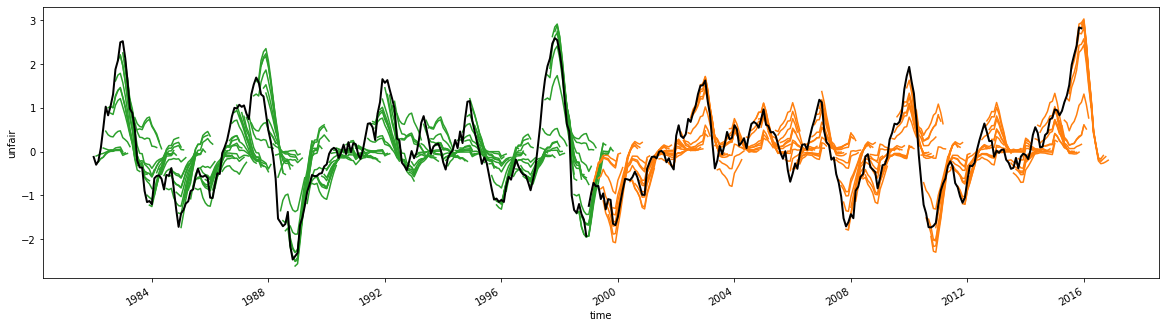

In [193]:
fig, ax = plt.subplots(figsize=(20,5))

obs_switch = reindex_forecast(add_target_time_coord(obs_nino34_switched[anom].sel(init_date=train_period)))
lin_switch = reindex_forecast(add_target_time_coord(regr_nino34_switched['linear regression'][anom].sel(init_date=train_period)))
for i in lin_switch.init_date:
    lin_switch.sel(init_date=i).plot(ax=ax, color='C2')

obs = reindex_forecast(add_target_time_coord(obs_nino34[anom].sel(init_date=test_period)))   
lin = reindex_forecast(add_target_time_coord(regr_nino34['linear regression'][anom].sel(init_date=test_period)))
for i in lin.init_date:
    lin.sel(init_date=i).plot(ax=ax, color='C1')

obs_plot = [obs_switch.where(obs_switch.lead_time==0, drop=True).sum('init_date'),
            obs.where(obs.lead_time==0, drop=True).sum('init_date')]
obs_plot[0].plot(color='k', linewidth=2)
obs_plot[1].plot(color='k', linewidth=2)

In [194]:
lead = 6
MSE = doppyo.skill.mean_squared_error(lin.where(lin.lead_time==lead, drop=True).sum('init_date'), 
                                      obs.where(obs.lead_time==lead, drop=True).sum('init_date'), over_dims='time').values
MSE_c = doppyo.skill.mean_squared_error(0, obs.where(obs.lead_time==lead, drop=True).sum('init_date'), 
                                        over_dims='time').values
MSE_switch = doppyo.skill.mean_squared_error(lin_switch.where(lin_switch.lead_time==lead, drop=True).sum('init_date'), 
                                             obs_switch.where(obs_switch.lead_time==lead, drop=True).sum('init_date'),  over_dims='time').values
MSE_switch_c = doppyo.skill.mean_squared_error(0, obs_switch.where(obs_switch.lead_time==lead, drop=True).sum('init_date'), 
                                               over_dims='time').values

In [195]:
print(f'MSE: {MSE}')
print(f'MSE climatology: {MSE_c}')
print(f'MSSS: {1 - (MSE / MSE_c)}')

MSE: 0.40598906571597776
MSE climatology: 0.832316291810842
MSSS: 0.5122178074483184


In [196]:
print(f'switched MSE: {MSE_switch}')
print(f'switched MSE climatology: {MSE_switch_c}')
print(f'switched MSSS: {1 - (MSE_switch / MSE_switch_c)}')

switched MSE: 0.6970053411648093
switched MSE climatology: 1.1151529411764711
switched MSSS: 0.37496883572805884


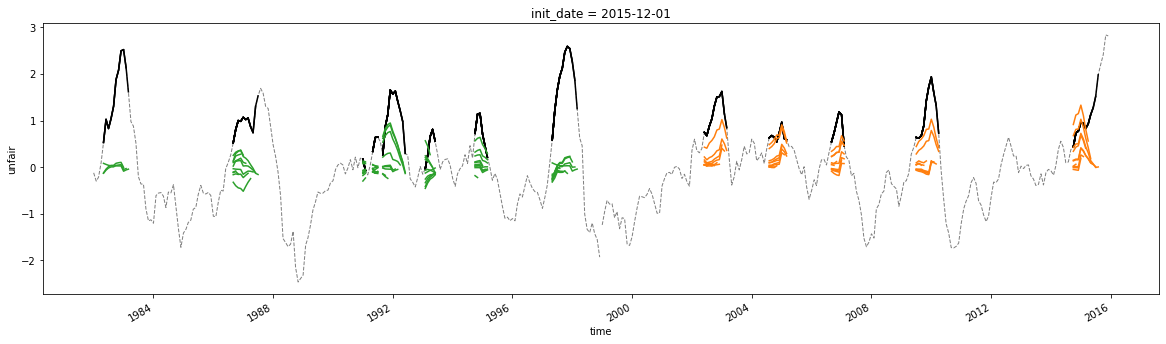

In [197]:
fig, ax = plt.subplots(figsize=(20,5))

obs_plot[0].plot(color='grey', linestyle='--', linewidth=1)
obs_plot[1].plot(color='grey', linestyle='--', linewidth=1)

obs_switch = reindex_forecast(add_target_time_coord(obs_nino34_switched[anom].where(mask).sel(init_date=train_period)))
for i in obs_switch.init_date:
    obs_switch.sel(init_date=i).plot(ax=ax, color='k')
lin_switch = reindex_forecast(add_target_time_coord(regr_nino34_switched['linear regression'][anom].where(mask).sel(init_date=train_period)))
for i in lin_switch.init_date:
    lin_switch.sel(init_date=i).plot(ax=ax, color='C2')

obs = reindex_forecast(add_target_time_coord(obs_nino34[anom].where(mask).sel(init_date=test_period)))  
for i in obs.init_date:
    obs.sel(init_date=i).plot(ax=ax, color='k')
lin = reindex_forecast(add_target_time_coord(regr_nino34['linear regression'][anom].where(mask).sel(init_date=test_period)))
for i in lin.init_date:
    lin.sel(init_date=i).plot(ax=ax, color='C1')
    
# obs_switch.where(obs_switch.lead_time==0, drop=True).sum('init_date').plot(color='k', linewidth=2)
# obs.where(obs.lead_time==0, drop=True).sum('init_date').plot(color='k', linewidth=2)

In [198]:
lead = 6
MSE = doppyo.skill.mean_squared_error(lin.where(lin.lead_time==lead, drop=True).sum('init_date'), 
                                      obs.where(obs.lead_time==lead, drop=True).sum('init_date'), over_dims='time').values
MSE_c = doppyo.skill.mean_squared_error(0, obs.where(obs.lead_time==lead, drop=True).sum('init_date'), 
                                        over_dims='time').values
MSE_switch = doppyo.skill.mean_squared_error(lin_switch.where(lin_switch.lead_time==lead, drop=True).sum('init_date'), 
                                             obs_switch.where(obs_switch.lead_time==lead, drop=True).sum('init_date'),  over_dims='time').values
MSE_switch_c = doppyo.skill.mean_squared_error(0, obs_switch.where(obs_switch.lead_time==lead, drop=True).sum('init_date'), 
                                               over_dims='time').values

In [199]:
print(f'MSE: {MSE}')
print(f'MSE climatology: {MSE_c}')
print(f'MSSS: {1 - (MSE / MSE_c)}')

MSE: 0.06645253937132894
MSE climatology: 0.12615988024967786
MSSS: 0.47326726024299137


In [200]:
print(f'switched MSE: {MSE_switch}')
print(f'switched MSE climatology: {MSE_switch_c}')
print(f'switched MSSS: {1 - (MSE_switch / MSE_switch_c)}')

switched MSE: 0.2088602122162845
switched MSE climatology: 0.22823144209240784
switched MSSS: 0.08487537781179233
